In [4]:
###### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, LeaveOneOut, KFold , GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Problem Definition

### Problem Definition

The objective of the Loan Approval Prediction project is to develop a machine learning model that accurately predicts the likelihood of loan approval based on various borrower characteristics and financial indicators. In the current lending landscape, financial institutions face significant challenges in assessing creditworthiness, which can lead to inefficiencies, increased risk of defaults, and potential customer dissatisfaction.

#### Key Issues:

- **Inefficiency in Traditional Processes**: Traditional loan approval methods often rely on manual assessments and rigid criteria, which can be time-consuming and prone to human error. This inefficiency can delay decisions, impacting both lenders and borrowers.

- **Subjectivity in Decision-Making**: Many lending decisions are influenced by subjective judgments, which can lead to inconsistencies in the approval process. This subjectivity may result in qualified applicants being denied loans or unqualified applicants being approved, leading to higher default rates.

- **Complexity of Borrower Profiles**: With a diverse range of borrowers, each with unique financial situations and backgrounds, it can be challenging for lenders to accurately assess risk. Factors such as income levels, employment history, and credit scores must be considered, but the interplay among these variables can be complex.

- **Need for Transparency**: Borrowers increasingly demand transparency in the lending process. Understanding the criteria that affect loan approval can build trust between lenders and borrowers, leading to a better customer experience.

- **Impact of Economic Factors**: Economic conditions, such as unemployment rates and interest rates, can significantly influence lending decisions. A robust predictive model must account for these external factors while assessing individual loan applications.

#### Project Goals:

The project aims to address these issues by creating a predictive model that:

- Streamlines the loan approval process by automating assessments.
- Reduces subjectivity by providing data-driven insights.
- Enhances risk assessment by identifying key factors influencing loan approval.
- Improves borrower experience by fostering transparency and understanding of the approval criteria.


# 2. Data Collection

### Data Collection

For this project, the dataset used for loan approval prediction is sourced from Kaggle. Specifically, the dataset can be found at the following link: [Loan Risk Prediction Dataset](https://www.kaggle.com/datasets/ganjerlawrence/loan-risk-prediction-dataset). This dataset contains a variety of attributes related to loan applicants, including personal information, financial indicators, and loan details.

The comprehensive nature of the dataset allows for in-depth analysis and modeling, making it an ideal choice for developing a predictive model. Each entry in the dataset represents a unique loan application, enabling the exploration of factors that influence loan approval decisions. By leveraging this data, we aim to uncover patterns that can enhance the decision-making process for lenders and improve the overall lending experience for borrowers.


# 3. Data preprocessing and Featue Selection

In [6]:
# importing necessary libraries and packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# for the table
import plotly.graph_objects as go

# package for blancing the dataset
from imblearn.over_sampling import SMOTE

# for filling missing value
from sklearn.impute import KNNImputer

# importing the models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# importing the ensemble models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
import xgboost

# feature selection
from sklearn.feature_selection import SequentialFeatureSelector

# importing the model_slection and peformance metrics packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, LeaveOneOut, KFold , GridSearchCV


In [7]:
# df = pd.read_csv("credit_risk.csv")
# df.head()

In [8]:
df = pd.read_csv("/content/drive/My Drive/datasets/Loan prediction mini dataset.csv")
df.head()

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,13116,23,88000,MORTGAGE,2.0,MEDICAL,6625,11.22,0,0.08,Y,3
1,1742,23,30000,RENT,0.0,PERSONAL,1925,12.18,0,0.06,N,2
2,27672,32,160000,MORTGAGE,9.0,DEBTCONSOLIDATION,12000,7.88,0,0.07,N,8
3,24694,29,75000,OWN,3.0,HOMEIMPROVEMENT,12000,7.51,0,0.16,N,5
4,1994,22,28800,RENT,2.0,VENTURE,14000,7.90,1,0.49,N,2


In [9]:
df.shape

(8145, 12)

![image](https://drive.google.com/file/d/12qV-1AFEiQMwem1PO-iOg0keSFja45sK/view?usp=drive_link)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8145 entries, 0 to 8144
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              8145 non-null   int64  
 1   Age             8145 non-null   int64  
 2   Income          8145 non-null   int64  
 3   Home            8145 non-null   object 
 4   Emp_length      7909 non-null   float64
 5   Intent          8145 non-null   object 
 6   Amount          8145 non-null   int64  
 7   Rate            7383 non-null   float64
 8   Status          8145 non-null   int64  
 9   Percent_income  8145 non-null   float64
 10  Default         8145 non-null   object 
 11  Cred_length     8145 non-null   int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 763.7+ KB


In [11]:
for column in df:
    print( column,": ", df[column].nunique())

Id :  8145
Age :  51
Income :  1641
Home :  4
Emp_length :  31
Intent :  6
Amount :  507
Rate :  297
Status :  2
Percent_income :  69
Default :  2
Cred_length :  29


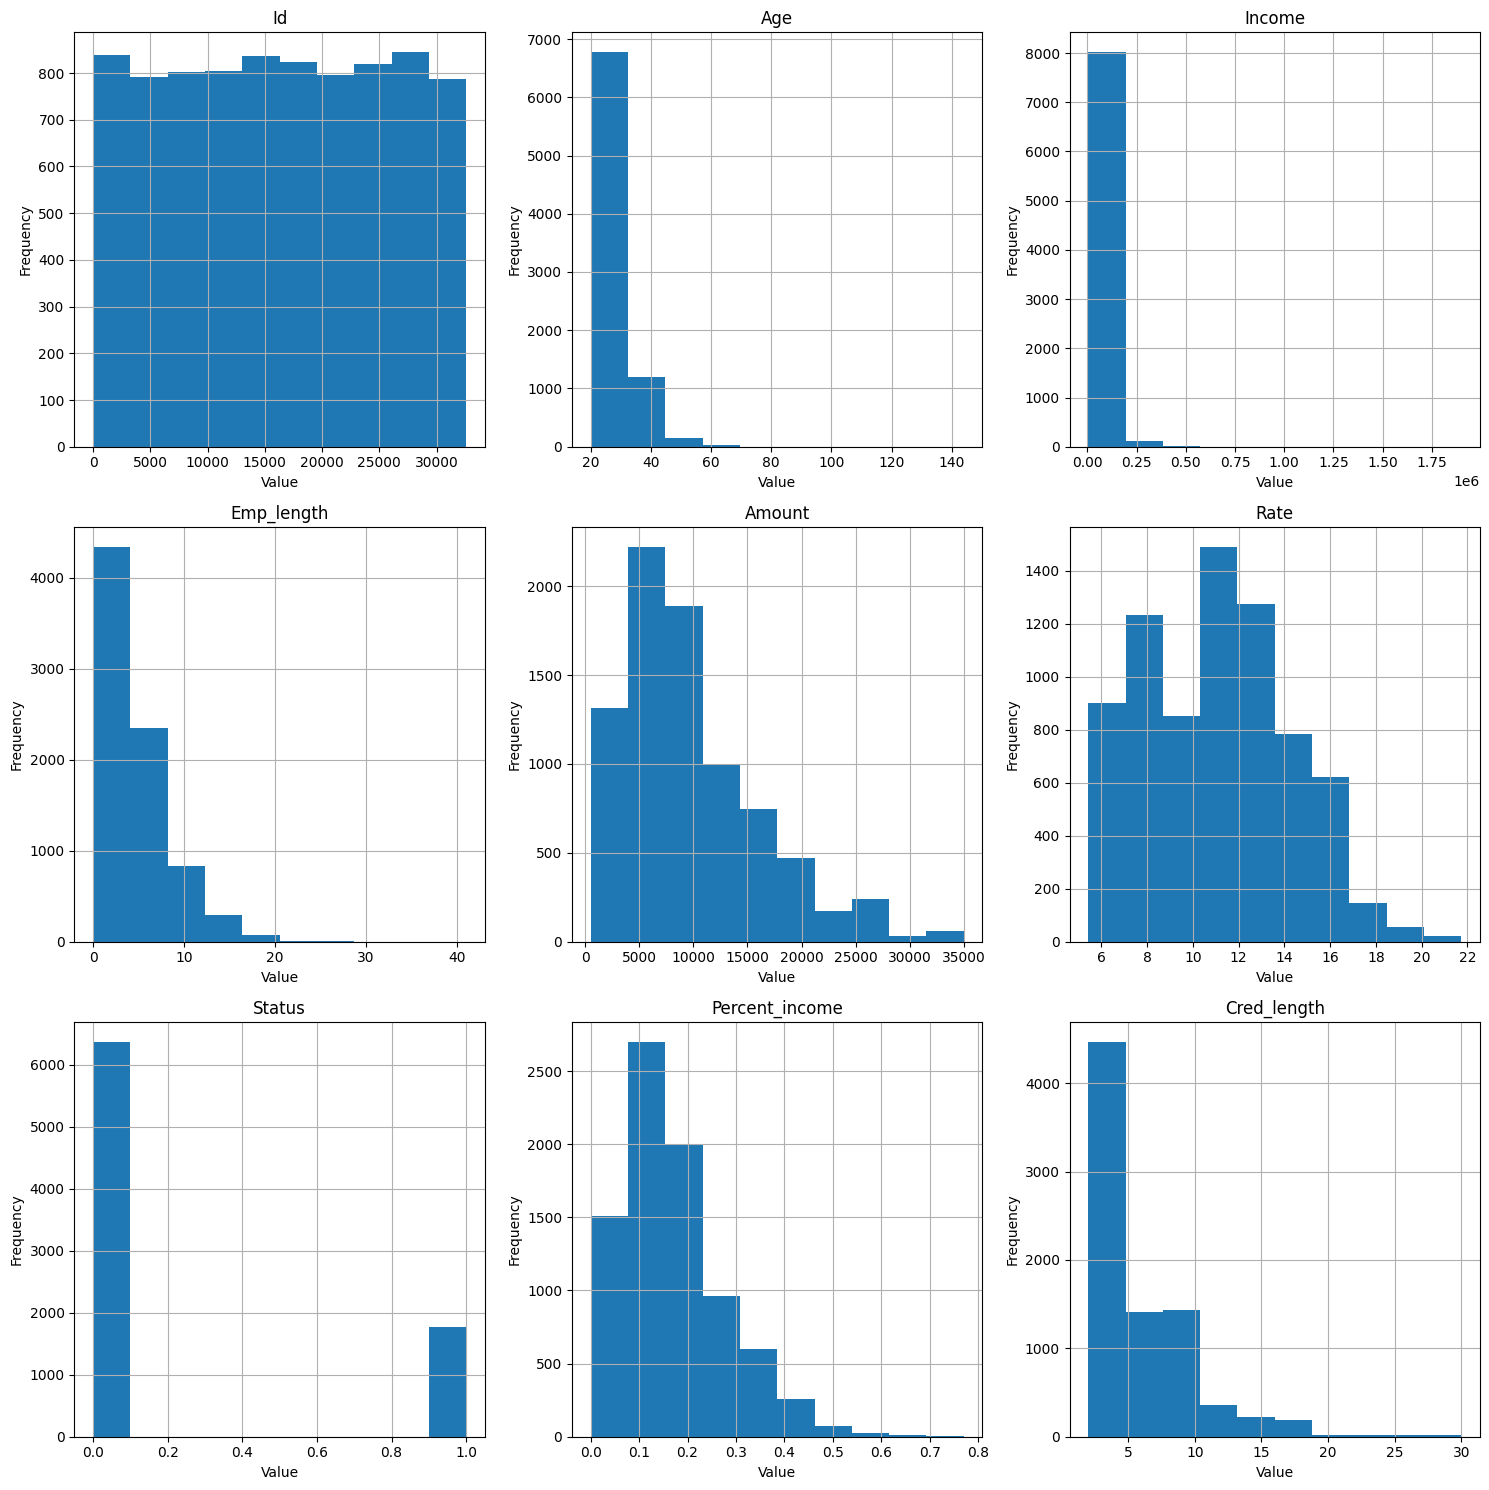

In [12]:
# Create a histogram for all numeric columns in the DataFrame
axes = df.hist(figsize=(15, 15))

# Loop through each subplot to set labels and title
for ax in axes.flatten():
    ax.set_xlabel('Value')  # Set x-axis label
    ax.set_ylabel('Frequency')  # Set y-axis label
    ax.set_title(ax.get_title())  # Set title for each subplot

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [13]:
df.head()

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,13116,23,88000,MORTGAGE,2.0,MEDICAL,6625,11.22,0,0.08,Y,3
1,1742,23,30000,RENT,0.0,PERSONAL,1925,12.18,0,0.06,N,2
2,27672,32,160000,MORTGAGE,9.0,DEBTCONSOLIDATION,12000,7.88,0,0.07,N,8
3,24694,29,75000,OWN,3.0,HOMEIMPROVEMENT,12000,7.51,0,0.16,N,5
4,1994,22,28800,RENT,2.0,VENTURE,14000,7.90,1,0.49,N,2


In [14]:
df = df.drop("Id", axis = 1)
df.head()

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,23,88000,MORTGAGE,2.0,MEDICAL,6625,11.22,0,0.08,Y,3
1,23,30000,RENT,0.0,PERSONAL,1925,12.18,0,0.06,N,2
2,32,160000,MORTGAGE,9.0,DEBTCONSOLIDATION,12000,7.88,0,0.07,N,8
3,29,75000,OWN,3.0,HOMEIMPROVEMENT,12000,7.51,0,0.16,N,5
4,22,28800,RENT,2.0,VENTURE,14000,7.90,1,0.49,N,2


## finding and filling missing value

In [15]:
df.isna().sum()

,0
Age,0
Income,0
Home,0
Emp_length,236
Intent,0
Amount,0
Rate,762
Status,0
Percent_income,0
Default,0


## encoding categorical values

In [16]:
# apply One hot Encoding
encoded_values = pd.get_dummies(df, columns=['Intent','Home'], dtype=int)
encoded_values.head()

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
0,23,88000,2.0,6625,11.22,0,0.08,Y,3,0,0,0,1,0,0,1,0,0,0
1,23,30000,0.0,1925,12.18,0,0.06,N,2,0,0,0,0,1,0,0,0,0,1
2,32,160000,9.0,12000,7.88,0,0.07,N,8,1,0,0,0,0,0,1,0,0,0
3,29,75000,3.0,12000,7.51,0,0.16,N,5,0,0,1,0,0,0,0,0,1,0
4,22,28800,2.0,14000,7.90,1,0.49,N,2,0,0,0,0,0,1,0,0,0,1


In [17]:
df = encoded_values
df.head(2)

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
0,23,88000,2.0,6625,11.22,0,0.08,Y,3,0,0,0,1,0,0,1,0,0,0
1,23,30000,0.0,1925,12.18,0,0.06,N,2,0,0,0,0,1,0,0,0,0,1


In [18]:
df['Default'] = df['Default'].map({'Y':1, 'N':0})
df.head()

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
0,23,88000,2.0,6625,11.22,0,0.08,1,3,0,0,0,1,0,0,1,0,0,0
1,23,30000,0.0,1925,12.18,0,0.06,0,2,0,0,0,0,1,0,0,0,0,1
2,32,160000,9.0,12000,7.88,0,0.07,0,8,1,0,0,0,0,0,1,0,0,0
3,29,75000,3.0,12000,7.51,0,0.16,0,5,0,0,1,0,0,0,0,0,1,0
4,22,28800,2.0,14000,7.90,1,0.49,0,2,0,0,0,0,0,1,0,0,0,1


In [19]:
df.shape

(8145, 19)

In [20]:
df['Rate'].value_counts()

,count
Rate,
7.51,195
10.99,183
7.88,174
7.49,167
5.42,147
...,...
12.36,1
18.49,1
14.67,1


In [21]:
missing_rate = df[df['Rate'].isna()]
missing_rate

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
18,29,55000,9.0,5000,NaN,0,0.09,0,8,0,0,1,0,0,0,1,0,0,0
21,36,35000,1.0,10000,NaN,0,0.29,0,15,0,0,0,0,0,1,0,0,0,1
24,22,90000,6.0,12000,NaN,0,0.13,0,4,0,0,0,0,0,1,0,0,0,1
45,26,62900,4.0,24250,NaN,1,0.33,1,2,0,0,0,1,0,0,0,0,1,0
49,23,25800,2.0,6000,NaN,0,0.23,1,4,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8077,26,80000,10.0,25000,NaN,0,0.31,0,3,0,0,0,0,0,1,1,0,0,0
8084,20,98000,4.0,24250,NaN,0,0.25,0,4,0,1,0,0,0,0,1,0,0,0
8094,24,57500,4.0,2525,NaN,0,0.04,0,4,1,0,0,0,0,0,0,0,0,1
8116,29,85200,5.0,8900,NaN,0,0.10,1,6,0,0,0,1,0,0,1,0,0,0


In [22]:
df[df['Emp_length'].isna()]

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
44,22,30000,NaN,3200,15.62,1,0.11,1,4,1,0,0,0,0,0,0,0,0,1
57,32,50000,NaN,10000,6.03,0,0.20,0,9,0,1,0,0,0,0,0,0,1,0
63,32,61200,NaN,15000,6.99,0,0.25,0,9,0,0,0,0,1,0,1,0,0,0
77,21,32000,NaN,8000,5.99,0,0.25,0,3,0,0,0,1,0,0,1,0,0,0
85,43,45000,NaN,2000,11.49,0,0.04,0,17,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7909,23,40800,NaN,21000,6.17,0,0.51,0,3,0,0,0,1,0,0,0,0,1,0
7933,22,42000,NaN,3200,7.90,1,0.08,0,3,0,0,0,0,1,0,1,0,0,0
7955,34,29152,NaN,5000,10.36,0,0.17,0,7,0,0,0,0,0,1,0,0,0,1
8018,24,46000,NaN,10000,15.99,1,0.22,0,3,0,0,0,1,0,0,1,0,0,0


## use KNN Inputer to fill in the missing Rate values

### for imputing , make sure to impute only the numerical columns with missing values

In [23]:
from sklearn.impute import KNNImputer
import pandas as pd

imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors
missing_fields_imputed = pd.DataFrame(imputer.fit_transform(df[['Emp_length','Rate']]), columns=['Emp_length','Rate'])



In [24]:
missing_fields_imputed.head()

,Emp_length,Rate
0,2.0,11.22
1,0.0,12.18
2,9.0,7.88
3,3.0,7.51
4,2.0,7.90


In [25]:
missing_fields_imputed.isna().sum()

,0
Emp_length,0
Rate,0


In [26]:
missing_fields_imputed.shape


(8145, 2)

In [27]:
df.isna().sum()

,0
Age,0
Income,0
Emp_length,236
Amount,0
Rate,762
Status,0
Percent_income,0
Default,0
Cred_length,0
Intent_DEBTCONSOLIDATION,0


In [28]:
df.head()

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
0,23,88000,2.0,6625,11.22,0,0.08,1,3,0,0,0,1,0,0,1,0,0,0
1,23,30000,0.0,1925,12.18,0,0.06,0,2,0,0,0,0,1,0,0,0,0,1
2,32,160000,9.0,12000,7.88,0,0.07,0,8,1,0,0,0,0,0,1,0,0,0
3,29,75000,3.0,12000,7.51,0,0.16,0,5,0,0,1,0,0,0,0,0,1,0
4,22,28800,2.0,14000,7.90,1,0.49,0,2,0,0,0,0,0,1,0,0,0,1


In [29]:
df_without_rate_Emp_length = df.drop(["Rate","Emp_length"], axis=1)
df_without_rate_Emp_length.head()

,Age,Income,Amount,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
0,23,88000,6625,0,0.08,1,3,0,0,0,1,0,0,1,0,0,0
1,23,30000,1925,0,0.06,0,2,0,0,0,0,1,0,0,0,0,1
2,32,160000,12000,0,0.07,0,8,1,0,0,0,0,0,1,0,0,0
3,29,75000,12000,0,0.16,0,5,0,0,1,0,0,0,0,0,1,0
4,22,28800,14000,1,0.49,0,2,0,0,0,0,0,1,0,0,0,1


### combining the df fields with the new ['Rate','Emp_length'] fields with no NA values

In [30]:
missing_fields_imputed.head()

,Emp_length,Rate
0,2.0,11.22
1,0.0,12.18
2,9.0,7.88
3,3.0,7.51
4,2.0,7.90


In [31]:
df_without_rate_Emp_length.shape

(8145, 17)

In [32]:
missing_fields_imputed.shape

(8145, 2)

In [33]:
new_df = pd.concat([df_without_rate_Emp_length, missing_fields_imputed],axis=1)
new_df.head()

,Age,Income,Amount,Status,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Emp_length,Rate
0,23,88000,6625,0,0.08,1,3,0,0,0,1,0,0,1,0,0,0,2.0,11.22
1,23,30000,1925,0,0.06,0,2,0,0,0,0,1,0,0,0,0,1,0.0,12.18
2,32,160000,12000,0,0.07,0,8,1,0,0,0,0,0,1,0,0,0,9.0,7.88
3,29,75000,12000,0,0.16,0,5,0,0,1,0,0,0,0,0,1,0,3.0,7.51
4,22,28800,14000,1,0.49,0,2,0,0,0,0,0,1,0,0,0,1,2.0,7.90


In [34]:
new_df.shape

(8145, 19)

In [35]:
new_df.isna().sum()

,0
Age,0
Income,0
Amount,0
Status,0
Percent_income,0
Default,0
Cred_length,0
Intent_DEBTCONSOLIDATION,0
Intent_EDUCATION,0
Intent_HOMEIMPROVEMENT,0


In [36]:
## updating the original df to contain the new_df withoud missing values
df = new_df

In [37]:
df.shape

(8145, 19)

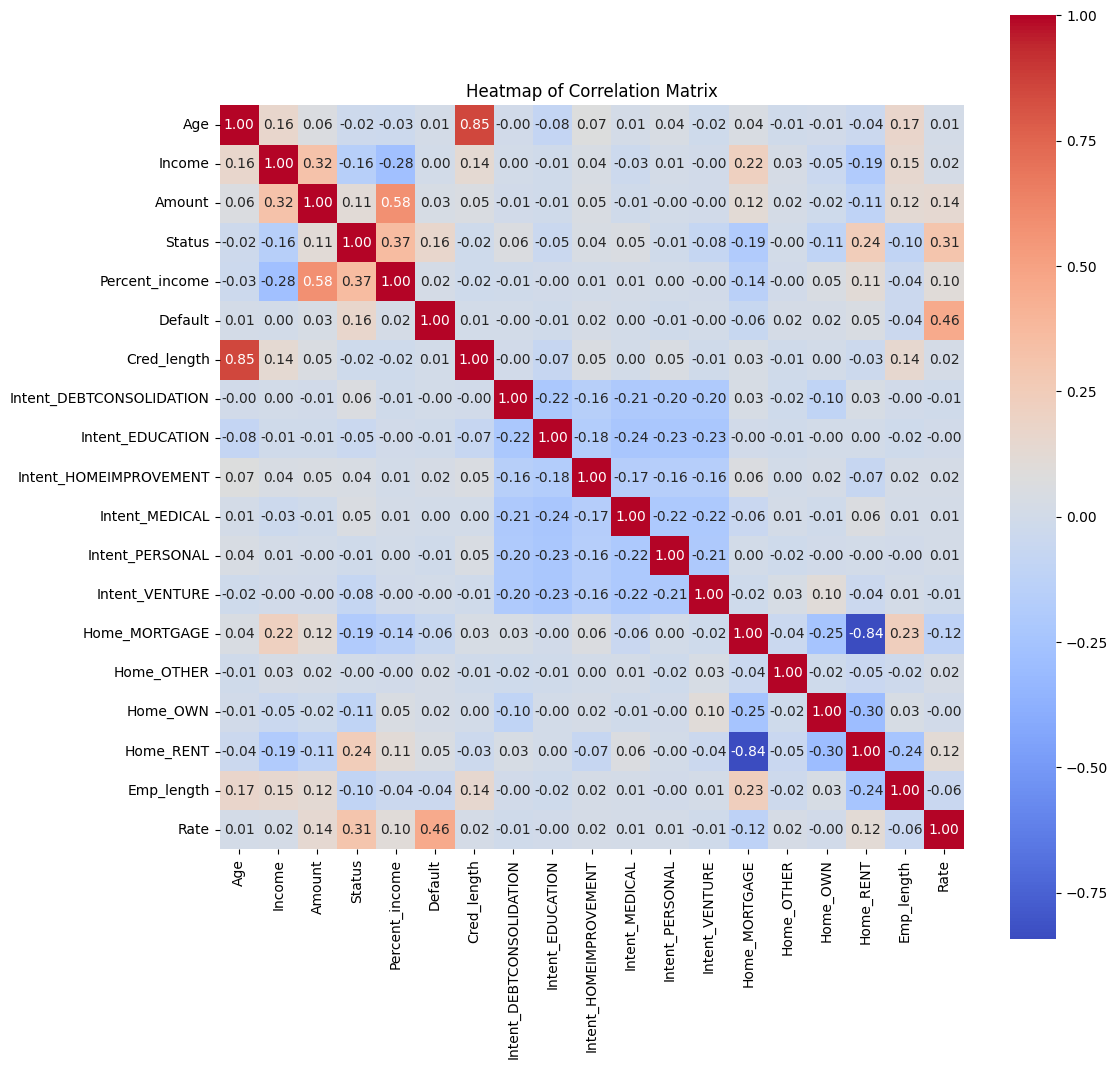

In [38]:
# Compute the correlation matrix
corr = df.corr()

# Create the heatmap
plt.figure(figsize=(12, 12))  # Set the size of the figure
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)

plt.title('Heatmap of Correlation Matrix')  # Add a title
plt.show()

In [39]:
# splitting the target values from the main dataframe since i don't want it to get scaled so i will just split the data here
target = df['Status']
features = df.drop('Status', axis=1)

In [40]:
# setting the sandom seed to ensure all random operations withing the project use the same seed
np.random.seed(42)

## Data set Spitting

## spliting the data set into feature(x) and target variable(y)

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.3)

## balancing the dataset using SMOTE

In [42]:
df['Status'].value_counts()

,count
Status,
0,6368
1,1777


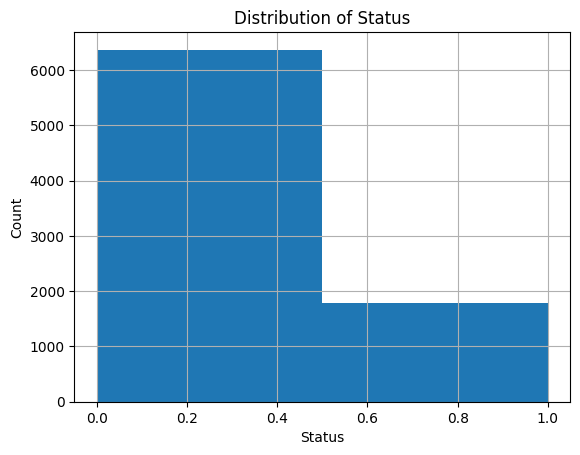

In [43]:
df['Status'].hist(bins=2)
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Distribution of Status')
plt.show()

In [44]:
# ! pip install imbalanced-learn

In [45]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_resampled, y_resampled = smote.fit_resample(features, target)


In [46]:
features = x_resampled
target = y_resampled
print(features.shape, target.shape)

(12736, 18) (12736,)


In [47]:
# now checking that the dataset is balanced
target.value_counts()

,count
Status,
0,6368
1,6368


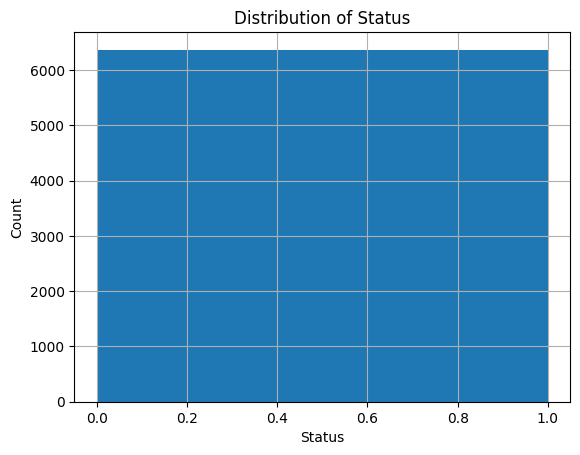

In [48]:
target.hist(bins=2)
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Distribution of Status')
plt.show()

# spliting the dataset into training , validation and testing set

### the use part will be used for the training and evaluation of the model while the temp part will be kept aside . part will be used for testing. the reason why am doing this is because the size of the dataset is large and due to this the model takes to long to train since i have limmited computing resource so i have to split the data in two parts so i can train the model faster.

In [49]:
from sklearn.model_selection import train_test_split
# splitting the data into 2 parts use and temp
x_use , x_temp, y_use, y_temp = train_test_split(features, target,test_size=1/4, stratify=target, random_state=42 )



In [50]:
print(" to be used " , x_use.shape, y_use.shape)
print(" to be kept " , x_temp.shape, y_temp.shape)

 to be used  (9552, 18) (9552,)
 to be kept  (3184, 18) (3184,)


In [51]:
# checking to ensure that the part we are going to use contains an even destribution of our target varable
y_use.value_counts()

,count
Status,
1,4776
0,4776


# preparing the Test data

In [52]:
x_temp.shape

(3184, 18)

In [53]:
"""
using StratifiedShuffleSplit fro sklearn to split the data into balanced parts
"""
from sklearn.model_selection import StratifiedShuffleSplit
test_pick = StratifiedShuffleSplit(n_splits=1, test_size=2/3, random_state=42)

In [54]:
x = x_temp
y = y_temp
for train_index, test_index in test_pick.split(x,y):
    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]


In [55]:
print(f" x_test shape : {x_test.shape} \n y_test shape : {y_test.shape}")

 x_test shape : (2123, 18) 
 y_test shape : (2123,)


In [56]:
y_test.value_counts()

,count
Status,
0,1062
1,1061


## splitting the usable part into training and validation set

In [57]:
x_use.shape

(9552, 18)

In [58]:
# spliting into training anv validation set using
x_train,x_val,y_train,y_val = train_test_split(x_use, y_use, test_size=0.25)

In [59]:
print(f"x_train{x_train.shape} \n x_val{x_val.shape} \n y_train{y_train.shape} \n y_val{y_val.shape}")

x_train(7164, 18) 
 x_val(2388, 18) 
 y_train(7164,) 
 y_val(2388,)


# 5. Model Selection

# 6. Model training (before Feature Selection)

For traing the models, i am going to follow 5 steps
#### 1. **Train with default parameters:** In this step, the models will be trained with their default parameters
#### 2. **Cross-Validation:** In this step, cross validation will be used to evaluate model's peformance on different subsets of the training data. This helps access the model's generalization ability and identify potential overfitting
#### 3. **Hyperparameter tunning:** In this step, we Tune the model's hyperparameters using technique like **Grid Search**
#### 4. **Retrain with best parameters:** In this step, the model is trained with the best parameters obtained from the previous step
#### 5. **Evaluate on Test set:** In this stage , the model is tested with the test set. This will give the final accessment of the model's peformance

# ◉ KNearestNeighbor model

## &rarr; Training the model with default parameters

In [60]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
st = time.time()
knn_model.fit(x_train, y_train)
et = time.time()
print("time taking to train the knn model is : ", et-st)
knn_model

time taking to train the knn model is :  0.00525975227355957


KNeighborsClassifier()

In [61]:
y_pred = knn_model.predict(x_val)

# 7.1 Model evalution for KNearestNeighbor classifier

In [62]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.78      0.73      0.75      1164
           1       0.76      0.81      0.78      1224

    accuracy                           0.77      2388
   macro avg       0.77      0.77      0.77      2388
weighted avg       0.77      0.77      0.77      2388



## &rarr; peforming cross-validation

## stratified K-Fold for KNN

In [63]:

skf = StratifiedKFold(n_splits=5)
st = time.time()
knn_model_skf_score = cross_val_score(knn_model, x_use, y_use, cv=skf)
et = time.time()
knn_model_skf_avg_score = round(knn_model_skf_score.mean(),3)
print("stratified kfold validation scores are : ", knn_model_skf_score)
print("average score for the stratifiec k fold  : ", knn_model_skf_avg_score )

print("time taken for stratified kfold cross validation on KNN is: ", et-st)


stratified kfold validation scores are :  [0.77969649 0.79173208 0.77382199 0.80104712 0.79267016]
average score for the stratifiec k fold  :  0.788
time taken for stratified kfold cross validation on KNN is:  1.233882188796997


## Leave One Out for KNN

In [64]:
# loov = LeaveOneOut()
# score = cross_val_score(model, x_use, y_use, cv=loov)
# print(score.mean())
# taking so much time so i left out

## K-Fold cross validation for KNN

In [65]:

kfold = KFold(n_splits=5)
st = time.time()
knn_model_kf_score = cross_val_score(knn_model, x_use, y_use, cv=kfold)
et = time.time()
knn_model_kf_avg_score = round(knn_model_kf_score.mean(), 3)
print(knn_model_kf_score)
print("the mean avg score for kfold cross validatin is :", knn_model_kf_avg_score)

print("time taken for kfold crossvalidaton: ", et-st)


[0.78021978 0.79434851 0.77382199 0.8        0.79162304]
the mean avg score for kfold cross validatin is : 0.788
time taken for kfold crossvalidaton:  1.08642578125


## &rarr; Hyper parameter tunning (KNeighborClassifier)

In [66]:
param_grid={
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_model_grid_search = GridSearchCV(knn_model, param_grid=param_grid, verbose=3, cv=5)
knn_model_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END n_neighbors=3, p=1, weights=uniform;, score=0.787 total time=   0.2s
[CV 2/5] END n_neighbors=3, p=1, weights=uniform;, score=0.795 total time=   0.2s
[CV 3/5] END n_neighbors=3, p=1, weights=uniform;, score=0.791 total time=   0.3s
[CV 4/5] END n_neighbors=3, p=1, weights=uniform;, score=0.793 total time=   0.2s
[CV 5/5] END n_neighbors=3, p=1, weights=uniform;, score=0.788 total time=   0.3s
[CV 1/5] END n_neighbors=3, p=1, weights=distance;, score=0.800 total time=   0.2s
[CV 2/5] END n_neighbors=3, p=1, weights=distance;, score=0.807 total time=   0.2s
[CV 3/5] END n_neighbors=3, p=1, weights=distance;, score=0.805 total time=   0.2s
[CV 4/5] END n_neighbors=3, p=1, weights=distance;, score=0.804 total time=   0.2s
[CV 5/5] END n_neighbors=3, p=1, weights=distance;, score=0.791 total time=   0.2s
[CV 1/5] END n_neighbors=3, p=2, weights=uniform;, score=0.780 total time=   0.2s
[CV 2/5] END n_neighbors=3, p=2

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [67]:
knn_best_parameters = knn_model_grid_search.best_params_
print(f"the best parameters for the knn model are : {knn_best_parameters}")

the best parameters for the knn model are : {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


## &rarr; Retrain with best parameters

In [68]:
final_knn_model = KNeighborsClassifier(n_neighbors=knn_best_parameters['n_neighbors'], p=knn_best_parameters['p'], weights=knn_best_parameters['weights'])
final_knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')

In [69]:
st = time.time()
y_pred = final_knn_model.predict(x_val)
et = time.time()
print("time taken to predict the validation data is : ", et-st)

time taken to predict the validation data is :  0.6142392158508301


In [70]:
final_knn_model_report = classification_report(y_val, y_pred)
print(final_knn_model_report)

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      1164
           1       0.79      0.82      0.81      1224

    accuracy                           0.80      2388
   macro avg       0.80      0.80      0.80      2388
weighted avg       0.80      0.80      0.80      2388



## &rarr; evaluate on test set (Testing the model)

In [71]:
st = time.time()
knn_test_pred = final_knn_model.predict(x_test)
et = time.time()
print("time taken to test the model is : ", et-st)

time taken to test the model is :  0.5703334808349609


In [72]:
knn_test_report = classification_report(y_test, knn_test_pred)
accuracy = accuracy_score(y_test, knn_test_pred)
knn_confusion_matrics = confusion_matrix(y_test, knn_test_pred)
print("accuracy : ", accuracy)
print(knn_test_report)
print("\n confussion matrics for Knn_model\n", knn_confusion_matrics)

accuracy :  0.8101742816768723
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1062
           1       0.80      0.82      0.81      1061

    accuracy                           0.81      2123
   macro avg       0.81      0.81      0.81      2123
weighted avg       0.81      0.81      0.81      2123


 confussion matrics for Knn_model
 [[848 214]
 [189 872]]


In [73]:
knn_test_accuracy = round(accuracy_score(y_test, knn_test_pred),3)
knn_test_recall = round(recall_score(y_test, knn_test_pred),3)
knn_test_precision = round(precision_score(y_test, knn_test_pred),3)
knn_test_f1_score = round(f1_score(y_test, knn_test_pred),3)

print("accuracy : ", knn_test_accuracy)
print("recall : ", knn_test_recall)
print("precision : ", knn_test_precision)
print("f1_score : ", knn_test_f1_score)

accuracy :  0.81
recall :  0.822
precision :  0.803
f1_score :  0.812


# ◉ Decision Tree Algorithm

## &rarr; Training the model with default parameters

In [74]:
from sklearn.tree import DecisionTreeClassifier
st = time.time()
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
et = time.time()
print("time taken to train the decision tree model: ", et-st)

time taken to train the decision tree model:  0.06456804275512695


In [75]:
y_pred = dt_model.predict(x_val)

# 7.2 Evaluation Report for Decision Tree Classifier

In [76]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1164
           1       0.89      0.89      0.89      1224

    accuracy                           0.89      2388
   macro avg       0.89      0.89      0.89      2388
weighted avg       0.89      0.89      0.89      2388



## &rarr; peforming cross-validation

## stratified k-Fold for Decision Tree Classifier

In [77]:
# skf stands for Stratified K-Fold

skf = StratifiedKFold(n_splits=5)
st = time.time()
dt_model_skf_score = cross_val_score(dt_model, x_use, y_use, cv=skf)
et = time.time()
dt_model_skf_avg_score = round(dt_model_skf_score.mean(),3)
print("Decision tree skf  average score : ", dt_model_skf_avg_score)
print(dt_model_skf_score)
print("time taken to do k-fold cross validation for decisionTree : ", et-st)

Decision tree skf  average score :  0.886
[0.8895866  0.87755102 0.88534031 0.8921466  0.88691099]
time taken to do k-fold cross validation for decisionTree :  0.3686859607696533


## K-Fold cross validation for Desision Tree Classifier

In [78]:
# kf stands for K-Fold

kf = KFold(n_splits=5)
st = time.time()
dt_model_kf_score = cross_val_score(dt_model, x_use, y_use, cv=kf)
et = time.time()
print(dt_model_kf_score)
dt_model_kf_avg_score = round(dt_model_kf_score.mean(),3)
print("Decision tree kf average score : ", dt_model_kf_avg_score)
print("time taken to do  cross validation for decisionTree : ", et-st)

[0.88749346 0.87022501 0.88691099 0.89005236 0.89267016]
Decision tree kf average score :  0.885
time taken to do  cross validation for decisionTree :  0.40402960777282715


## &rarr; Hyper parameter tunning

In [79]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

dt_model_grid_search = GridSearchCV(dt_model, param_grid=param_grid, verbose=3, cv=5)
dt_model_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.875 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.883 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.895 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.865 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.885 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.881 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.890 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.904 total time=  

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=3)

In [80]:
dt_model_best_parameters = dt_model_grid_search.best_params_
print(f"the best parameters for the decision tree model are : {dt_model_best_parameters}")

the best parameters for the decision tree model are : {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


## &rarr; Retrain the model with best parameters

In [81]:
final_dt_model = DecisionTreeClassifier(criterion=dt_model_best_parameters['criterion'], max_depth= dt_model_best_parameters['max_depth'], min_samples_leaf=dt_model_best_parameters['min_samples_leaf'], min_samples_split=dt_model_best_parameters['min_samples_split'])
final_dt_model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=10)

In [82]:
y_pred = final_dt_model.predict(x_val)

In [83]:
final_dt_report = classification_report(y_val, y_pred)
print(final_dt_report)

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1164
           1       0.95      0.84      0.89      1224

    accuracy                           0.90      2388
   macro avg       0.90      0.90      0.90      2388
weighted avg       0.90      0.90      0.90      2388



## &rarr; Evaluate on Test set (Testing the Decision tree model)

In [84]:
dt_test_pred = final_dt_model.predict(x_test)

In [85]:
dt_test_rport = classification_report(y_test, dt_test_pred)
accuracy = accuracy_score(y_test, dt_test_pred)
print("accuracy : ", accuracy)
print(dt_test_rport)

accuracy :  0.8959020254357042
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1062
           1       0.95      0.83      0.89      1061

    accuracy                           0.90      2123
   macro avg       0.90      0.90      0.90      2123
weighted avg       0.90      0.90      0.90      2123



In [86]:
dt_test_accuracy = round(accuracy_score(y_test, dt_test_pred),3)
dt_test_recall = round(recall_score(y_test, dt_test_pred),3)
dt_test_precision = round(precision_score(y_test, dt_test_pred),3)
dt_test_f1_score = round(f1_score(y_test, dt_test_pred),3)

print("accuracy : ", dt_test_accuracy)
print("recall : ", dt_test_recall)
print("precision : ", dt_test_precision)
print("f1_score : ", dt_test_f1_score)

accuracy :  0.896
recall :  0.832
precision :  0.954
f1_score :  0.889


# ◉ Logistic Regression

## &rarr; Train model with default parameters

In [87]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=6000, solver='liblinear')
st = time.time()
lr_model.fit(x_train, y_train)
et = time.time()
print("time taken to train the logistic regression model is : ", et-st)
lr_model

time taken to train the logistic regression model is :  0.033084869384765625


LogisticRegression(max_iter=6000, solver='liblinear')

In [88]:
y_pred = lr_model.predict(x_val)

## 7.3 Evaluation Report for Logistic Regression

In [89]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.76      0.66      0.71      1164
           1       0.71      0.79      0.75      1224

    accuracy                           0.73      2388
   macro avg       0.73      0.73      0.73      2388
weighted avg       0.73      0.73      0.73      2388



## &rarr; peforming cross validation

# Stratified K-Fold for Logistic Regression

In [90]:
skf = StratifiedKFold(n_splits=5)
st = time.time()
lr_model_skf_score = cross_val_score(lr_model, x_use, y_use, cv=skf)
et = time.time()
print("time taken for stratified kfold cross validation on Logistic Regression is: ", et-st)
lr_model_skf_avg_score = round(lr_model_skf_score.mean(),3)
print("the Stratified k-fold sore for logistic regression model is : " , lr_model_skf_score)
print("the Stratified k-fold average sore for logistic regression model is : " , lr_model_skf_avg_score)

time taken for stratified kfold cross validation on Logistic Regression is:  0.26761913299560547
the Stratified k-fold sore for logistic regression model is :  [0.73940345 0.73626374 0.73141361 0.74554974 0.73455497]
the Stratified k-fold average sore for logistic regression model is :  0.737


## K-Fold cross validation for Logistic Regression

In [91]:
kf = KFold(n_splits=5)
st = time.time()
lr_model_kf_score = cross_val_score(lr_model, x_use, y_use, cv=kf)
et = time.time()
lr_model_kf_avg_score = round(lr_model_kf_score.mean(),3)
print("the stratified k-fold score for linear regresion model is :", lr_model_kf_score)
print("the stratified k-fold avg score for linear regresion model is :", lr_model_kf_avg_score)

the stratified k-fold score for linear regresion model is : [0.74306646 0.73260073 0.73141361 0.74502618 0.73141361]
the stratified k-fold avg score for linear regresion model is : 0.737


## &rarr; Hyper parameter tunning

In [92]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1,10],
    'solver':['liblinear']
    # linear solver accepts only l2 penalty so no need to include penalties
}
st = time.time()
lr_model_grid_search = GridSearchCV(lr_model, param_grid, cv=5, verbose=3, scoring='accuracy')
et = time.time()
print("time taken for hyper parameter tunning on Logistic Regression is: ", et-st)

lr_model_grid_search.fit(x_train, y_train)

time taken for hyper parameter tunning on Logistic Regression is:  0.00011992454528808594
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .........C=0.001, solver=liblinear;, score=0.755 total time=   0.0s
[CV 2/5] END .........C=0.001, solver=liblinear;, score=0.732 total time=   0.0s
[CV 3/5] END .........C=0.001, solver=liblinear;, score=0.736 total time=   0.0s
[CV 4/5] END .........C=0.001, solver=liblinear;, score=0.744 total time=   0.0s
[CV 5/5] END .........C=0.001, solver=liblinear;, score=0.743 total time=   0.0s
[CV 1/5] END ..........C=0.01, solver=liblinear;, score=0.753 total time=   0.0s
[CV 2/5] END ..........C=0.01, solver=liblinear;, score=0.733 total time=   0.0s
[CV 3/5] END ..........C=0.01, solver=liblinear;, score=0.731 total time=   0.0s
[CV 4/5] END ..........C=0.01, solver=liblinear;, score=0.742 total time=   0.0s
[CV 5/5] END ..........C=0.01, solver=liblinear;, score=0.741 total time=   0.0s
[CV 1/5] END ...........C=0.1, solver=li

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=6000, solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'solver': ['liblinear']},
             scoring='accuracy', verbose=3)

In [93]:
lr_model_best_parameters = lr_model_grid_search.best_params_
print(lr_model_best_parameters)

{'C': 0.001, 'solver': 'liblinear'}


## &rarr; Retrain with best parameters

In [94]:
final_lr_model = LogisticRegression(C=lr_model_best_parameters['C'], solver=lr_model_best_parameters['solver'])
st = time.time()
final_lr_model.fit(x_train, y_train)
et = time.time()
print("time taken to train the model is : ", et-st)

time taken to train the model is :  0.03954792022705078


In [95]:
y_pred = final_lr_model.predict(x_val)

In [96]:
final_lr_model_report = classification_report(y_val, y_pred)
print(final_lr_model_report)

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1164
           1       0.72      0.79      0.76      1224

    accuracy                           0.74      2388
   macro avg       0.74      0.74      0.74      2388
weighted avg       0.74      0.74      0.74      2388



## &rarr; Evaluate on test set (Testing the model )

In [97]:
lr_test_pred = final_lr_model.predict(x_test)

In [98]:
lr_test_report = classification_report(y_test, lr_test_pred)
print(lr_test_report)

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1062
           1       0.72      0.77      0.75      1061

    accuracy                           0.74      2123
   macro avg       0.74      0.74      0.74      2123
weighted avg       0.74      0.74      0.74      2123



In [99]:
lr_test_accuracy = round(accuracy_score(y_test, lr_test_pred),3)
lr_test_recall = round(recall_score(y_test, lr_test_pred),3)
lr_test_precision = round(precision_score(y_test, lr_test_pred),3)
lr_test_f1_score = round(f1_score(y_test, lr_test_pred),3)

print("accuracy : ", lr_test_accuracy)
print("recall : ", lr_test_recall)
print("precision : ", lr_test_precision)
print("f1_score : ", lr_test_f1_score)

accuracy :  0.737
recall :  0.775
precision :  0.72
f1_score :  0.746


# ◉ Naive Bayes Algorithm

## &rarr; Training the model with default parameter

In [100]:
st = time.time()
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)
et = time.time()
print("time taken to train the GaussianNB model is : ", et-st)

time taken to train the GaussianNB model is :  0.009009599685668945


In [101]:
y_pred = nb_model.predict(x_val)

# 7.4 Model evaluation for GaussianNB

In [102]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.79      0.52      0.62      1164
           1       0.65      0.87      0.74      1224

    accuracy                           0.70      2388
   macro avg       0.72      0.69      0.68      2388
weighted avg       0.72      0.70      0.68      2388



## &rarr; Peforming cross validation

## stratified K-Fold for GaussianNB

In [103]:
skf = StratifiedKFold(n_splits=5)
st = time.time()
nb_model_skf_score = cross_val_score(nb_model, x_use, y_use, cv=skf)
et = time.time()
print("time taken for stratified kfold cross validation on GaussianNB is: ", et-st)
print(nb_model_skf_score)
nb_model_skf_avg_score = round(nb_model_skf_score.mean(),3)
print("GaussianNB stratified k-fold score : ", nb_model_skf_avg_score)

time taken for stratified kfold cross validation on GaussianNB is:  0.05938005447387695
[0.68131868 0.64782836 0.65183246 0.6486911  0.64450262]
GaussianNB stratified k-fold score :  0.655


## K-Fold for GaussianNB

In [104]:
kf = KFold(n_splits=5)
st = time.time()
nb_model_kf_score = cross_val_score(nb_model, x_use, y_use, cv=kf)
et = time.time()
print("time taken for kfold cross validation on GaussianNB is: ", et-st)
print(nb_model_kf_score)
nb_model_kf_avg_score = round(nb_model_kf_score.mean(),3)

print("the mean avg score for GausianNB kfold cross validatin is :", nb_model_kf_avg_score)

time taken for kfold cross validation on GaussianNB is:  0.0661013126373291
[0.68288854 0.6425955  0.66020942 0.6408377  0.64764398]
the mean avg score for GausianNB kfold cross validatin is : 0.655


## &rarr; Hyper Parameter tunning

In [105]:
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

nb_model_grid_search = GridSearchCV(nb_model, param_grid=param_grid, verbose=3, cv=5)
nb_model_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............var_smoothing=1e-09;, score=0.694 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-09;, score=0.683 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-09;, score=0.688 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-09;, score=0.692 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-09;, score=0.678 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-08;, score=0.669 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-08;, score=0.645 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-08;, score=0.666 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-08;, score=0.660 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-08;, score=0.647 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-07;, score=0.639 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-07;,

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]},
             verbose=3)

In [106]:
nb_model_best_parameters = nb_model_grid_search.best_params_
print(nb_model_best_parameters)

{'var_smoothing': 1e-09}


## &rarr; Retrain the model with best parameters

In [107]:
final_nb_model = GaussianNB(var_smoothing=nb_model_best_parameters['var_smoothing'])
final_nb_model.fit(x_train, y_train)

GaussianNB()

In [108]:
y_pred = final_nb_model.predict(x_val)

In [109]:
final_nb_model_report = classification_report(y_val,y_pred)
print(final_nb_model_report)

              precision    recall  f1-score   support

           0       0.79      0.52      0.62      1164
           1       0.65      0.87      0.74      1224

    accuracy                           0.70      2388
   macro avg       0.72      0.69      0.68      2388
weighted avg       0.72      0.70      0.68      2388



## &rarr; Evaluate GaussianNB model on the test set

In [110]:
nb_test_pred = final_nb_model.predict(x_test)

In [111]:
nb_test_report = classification_report(y_test, nb_test_pred)
print(nb_test_report)

              precision    recall  f1-score   support

           0       0.79      0.54      0.64      1062
           1       0.65      0.85      0.74      1061

    accuracy                           0.70      2123
   macro avg       0.72      0.70      0.69      2123
weighted avg       0.72      0.70      0.69      2123



In [112]:
nb_test_accuracy = round(accuracy_score(y_test, nb_test_pred),3)
nb_test_recall = round(recall_score(y_test, nb_test_pred),3)
nb_test_precision = round(precision_score(y_test, nb_test_pred),3)
nb_test_f1_score = round(f1_score(y_test, nb_test_pred),3)

print("accuracy : ", nb_test_accuracy)
print("recall : ", nb_test_recall)
print("precision : ", nb_test_precision)
print("f1_score : ", nb_test_f1_score)

accuracy :  0.697
recall :  0.853
precision :  0.65
f1_score :  0.738


# ◉ Support Vector Classifier

## &rarr; Train with default parameters

In [113]:
st = time.time()
svc_model = SVC()
et = time.time()
svc_model.fit(x_train, y_train)

SVC()

In [114]:
y_pred = svc_model.predict(x_val)

## 7.5 Model evaluation for Support Vector Classifier

In [115]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.66      0.74      0.70      1164
           1       0.72      0.64      0.68      1224

    accuracy                           0.69      2388
   macro avg       0.69      0.69      0.69      2388
weighted avg       0.69      0.69      0.69      2388



## &rarr; Peforming cross-validation

## stratified K-fold for SVC

In [116]:

skf = StratifiedKFold(n_splits=5)
st = time.time()
svc_model_skf_score = cross_val_score(svc_model, x_use, y_use, cv=skf)
et = time.time()
svc_model_skf_avg_score = round(svc_model_skf_score.mean(),3)

print("time taken for stratified kfold cross validation on SVC is: ", et-st)
print(svc_model_skf_score)
print("the mean avg score for SVC kfold cross validatin is :", svc_model_skf_avg_score)


time taken for stratified kfold cross validation on SVC is:  20.64986801147461
[0.70591313 0.69754055 0.68167539 0.71204188 0.7052356 ]
the mean avg score for SVC kfold cross validatin is : 0.7


## K-Fold cross vallidation for SVC

In [117]:

kf = KFold(n_splits=5)
st = time.time()
svc_model_kf_score = cross_val_score(svc_model, x_use, y_use, cv=kf)
et = time.time()
svc_model_kf_avg_score = round(svc_model_kf_score.mean(),3)
print(svc_model_kf_score)
print("the mean avg score for SVC kfold cross validatin is :", svc_model_kf_avg_score)

print("time taken for kfold crossvalidaton: ", et-st)

[0.70486656 0.69544741 0.67905759 0.71465969 0.70366492]
the mean avg score for SVC kfold cross validatin is : 0.7
time taken for kfold crossvalidaton:  20.18903160095215


## &rarr; Hyper parameter tunning

In [118]:
# commented it out because is taking too long to execute
param_grid = {
    'C': [0.1, 1, 2,5, 10,15,20,50, 100]

}

svc_model_grid_search = GridSearchCV(svc_model, param_grid=param_grid, verbose=3, cv=5)
svc_model_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .............................C=0.1;, score=0.681 total time=   1.9s
[CV 2/5] END .............................C=0.1;, score=0.693 total time=   1.8s
[CV 3/5] END .............................C=0.1;, score=0.715 total time=   1.9s
[CV 4/5] END .............................C=0.1;, score=0.689 total time=   1.9s
[CV 5/5] END .............................C=0.1;, score=0.697 total time=   2.4s
[CV 1/5] END ...............................C=1;, score=0.693 total time=   3.0s
[CV 2/5] END ...............................C=1;, score=0.698 total time=   2.0s
[CV 3/5] END ...............................C=1;, score=0.717 total time=   1.8s
[CV 4/5] END ...............................C=1;, score=0.703 total time=   1.8s
[CV 5/5] END ...............................C=1;, score=0.709 total time=   1.8s
[CV 1/5] END ...............................C=2;, score=0.696 total time=   1.8s
[CV 2/5] END ...............................C=2;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 2, 5, 10, 15, 20, 50, 100]}, verbose=3)

In [119]:
svc_model_best_parameters = svc_model_grid_search.best_params_
print(svc_model_best_parameters)

{'C': 10}


## &rarr; Retrain SVC with best parameter

In [120]:
final_svc_model = SVC(C=svc_model_best_parameters['C'])
final_svc_model.fit(x_train, y_train)

SVC(C=10)

In [121]:
y_pred = final_svc_model.predict(x_val)

In [122]:
final_svc_model_report = classification_report(y_val, y_pred)
print(final_svc_model_report)

              precision    recall  f1-score   support

           0       0.65      0.78      0.71      1164
           1       0.75      0.60      0.67      1224

    accuracy                           0.69      2388
   macro avg       0.70      0.69      0.69      2388
weighted avg       0.70      0.69      0.69      2388



## &rarr; Evalate on test set (Testing the SVC model)

In [123]:
svc_test_pred = final_svc_model.predict(x_test)

In [124]:
svc_test_report = classification_report(y_test, svc_test_pred)
print(svc_test_report)

              precision    recall  f1-score   support

           0       0.67      0.79      0.72      1062
           1       0.74      0.61      0.67      1061

    accuracy                           0.70      2123
   macro avg       0.71      0.70      0.70      2123
weighted avg       0.71      0.70      0.70      2123



In [125]:
svc_test_accracy = round(accuracy_score(y_test, svc_test_pred),3)
svc_test_recall = round(recall_score(y_test, svc_test_pred),3)
svc_test_precision = round(precision_score(y_test, svc_test_pred),3)
svc_test_f1_score = round(f1_score(y_test, svc_test_pred),3)

print("accuracy : ", svc_test_accracy)
print("recall : ", svc_test_recall)
print("precision : ", svc_test_precision)
print("f1_score : ", svc_test_f1_score)

accuracy :  0.699
recall :  0.61
precision :  0.743
f1_score :  0.67


# Ensemble models

# ◉ Random Forest Classifier

## &rarr; Train With Default parameters

In [126]:
from sklearn.ensemble import RandomForestClassifier
st = time.time()
rf_model = RandomForestClassifier()
et = time.time()
print("time taken to train the random forest model is : ", et-st)
rf_model.fit(x_train, y_train)

time taken to train the random forest model is :  0.00020074844360351562


RandomForestClassifier()

In [127]:
y_pred = rf_model.predict(x_val)

# **7.6 Model Evaluation for Random Forest Classifier**

In [128]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1164
           1       0.97      0.90      0.93      1224

    accuracy                           0.94      2388
   macro avg       0.94      0.94      0.94      2388
weighted avg       0.94      0.94      0.94      2388



## &rarr; Peforming cross- validation

## Stratified K-Fold for Random Forest Classifier

In [129]:

skf = StratifiedKFold(n_splits=5)
st = time.time()
rf_model_skf_score = cross_val_score(rf_model, x_use, y_use, cv=skf)
et = time.time()
rf_model_skf_avg_score = round(rf_model_skf_score.mean(),3)

print("time taken for stratified kfold cross validation on Random Forest is: ", et-st)
print(rf_model_skf_score)
print("the mean avg score for Random Forest Classifier kfold cross validatin is :", rf_model_skf_avg_score)


time taken for stratified kfold cross validation on Random Forest is:  6.809879302978516
[0.9392988  0.9314495  0.92565445 0.93141361 0.93403141]
the mean avg score for Random Forest Classifier kfold cross validatin is : 0.932


## K-Fold cross validation for Random Forest Classifier

In [130]:

kf = KFold(n_splits=5)
st = time.time()
rf_model_kf_score = cross_val_score(rf_model, x_use, y_use, cv=kf)
et = time.time()
rf_model_kf_avg_score = round(rf_model_kf_score.mean(),3)

print("time taken for kfold cross validation on Random Forest is: ", et-st)
print(rf_model_kf_score)
print("the mean avg score for Random Forest Classifier kfold cross validatin is :", rf_model_kf_avg_score)


time taken for kfold cross validation on Random Forest is:  5.65774130821228
[0.94191523 0.93354265 0.92513089 0.93141361 0.93246073]
the mean avg score for Random Forest Classifier kfold cross validatin is : 0.933


## &rarr; Hyper parameter tunning Random Forest Classifier

In [131]:
param_grid = {
    'n_estimators': [50, 100,150, 200],
    'max_depth': [None, 10, 20, 30],

}

rf_model_grid_search = GridSearchCV(rf_model, param_grid=param_grid, cv=5)
rf_model_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [50, 100, 150, 200]})

In [132]:
rf_model_best_parameters = rf_model_grid_search.best_params_
print(rf_model_best_parameters)

{'max_depth': 30, 'n_estimators': 50}


In [133]:
# since fine tunning the random forest model takes a long time aroung 40minutes i decided to just save the best parameters to use when needed to avoid running the tunning again
# rf_model_best_parameters = {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# print(rf_model_best_parameters)

## &rarr; Retrain the RandomForest model with best parameters

In [134]:
final_rf_model = RandomForestClassifier(n_estimators=rf_model_best_parameters['n_estimators'], max_depth=rf_model_best_parameters['max_depth'])
final_rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=50)

In [135]:
y_pred = final_rf_model.predict(x_val)

In [136]:
final_rf_model_report = classification_report(y_val, y_pred)
print(final_rf_model_report)

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1164
           1       0.97      0.90      0.93      1224

    accuracy                           0.93      2388
   macro avg       0.93      0.93      0.93      2388
weighted avg       0.94      0.93      0.93      2388



## &rarr; Evaluate on test set (Testing the model )

In [137]:
rf_test_pred = final_rf_model.predict(x_test)

In [138]:
rf_test_report = classification_report(y_test, rf_test_pred)
print(rf_test_report)

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1062
           1       0.96      0.89      0.93      1061

    accuracy                           0.93      2123
   macro avg       0.93      0.93      0.93      2123
weighted avg       0.93      0.93      0.93      2123



In [139]:
rf_test_accuracy = round(accuracy_score(y_test, rf_test_pred),3)
rf_test_recall = round(recall_score(y_test, rf_test_pred),3)
rf_test_precision = round(precision_score(y_test, rf_test_pred),3)
rf_test_f1_score = round(f1_score(y_test, rf_test_pred),3)

print("accuracy : ", rf_test_accuracy)
print("recall : ", rf_test_recall)
print("precision : ", rf_test_precision)
print("f1_score : ", rf_test_f1_score)

accuracy :  0.928
recall :  0.891
precision :  0.962
f1_score :  0.925


# ◉ Bagging Classifier

## &rarr; Training the model with default parameters

In [140]:
from sklearn.ensemble import BaggingClassifier
st = time.time()
bagging = BaggingClassifier()
et = time.time()
bagging.fit(x_train, y_train)

print("time taken to train the model is: ", et-st)
bagging

time taken to train the model is:  0.00014472007751464844


BaggingClassifier()

In [141]:
y_pred = bagging.predict(x_val)

## 7.6 Model Evaluation for BaggingClassifier

In [142]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1164
           1       0.96      0.88      0.92      1224

    accuracy                           0.92      2388
   macro avg       0.92      0.92      0.92      2388
weighted avg       0.92      0.92      0.92      2388



## &rarr; Peforming Cross-Validation

## KFold cross validation for BaggingClassifier

In [143]:

kf = KFold(n_splits=5)
st = time.time()
bagging_kf_score = cross_val_score(bagging, x_use, y_use, cv=kf)
et = time.time()
bagging_kf_avg_score = round(bagging_kf_score.mean(),3)
print("time taken for kfold cross validation on Bagging Classifier is: ", et-st)
print(bagging_kf_score)
print("the mean avg score for Bagging Classifier kfold cross validatin is :", bagging_kf_avg_score)

time taken for kfold cross validation on Bagging Classifier is:  1.6889889240264893
[0.91522763 0.9314495  0.91727749 0.92408377 0.91989529]
the mean avg score for Bagging Classifier kfold cross validatin is : 0.922


## Stratified K-Fold for BaggingClassifier

In [144]:

skf = StratifiedKFold(n_splits=5)
st = time.time()
bagging_skf_score = cross_val_score(bagging, x_use, y_use, cv=skf)
et = time.time()
bagging_skf_avg_score = round(bagging_skf_score.mean(),3)

print("time taken for stratified kfold cross validation on Bagging Classifier is: ", et-st)
print(bagging_skf_score)
print("the mean avg score for Bagging Classifier kfold cross validatin is :", bagging_skf_avg_score)

time taken for stratified kfold cross validation on Bagging Classifier is:  1.6611723899841309
[0.91575092 0.92203035 0.91884817 0.91989529 0.92356021]
the mean avg score for Bagging Classifier kfold cross validatin is : 0.92


## &rarr; Hyper Parameter tunning for BaggingClassifier

[view the bagging parameter tunning here](https://drive.google.com/file/d/12qV-1AFEiQMwem1PO-iOg0keSFja45sK/view?usp=drive_link)

In [145]:
param_grid = {
    'n_estimators': [75, 135, 150, 200],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0]
}

bagging_grid_search = GridSearchCV(bagging, param_grid=param_grid, cv=5)
bagging_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=BaggingClassifier(),
             param_grid={'max_features': [0.5, 1.0], 'max_samples': [0.5, 1.0],
                         'n_estimators': [75, 135, 150, 200]})

In [146]:
bagging_best_parameters = bagging_grid_search.best_params_
print(bagging_best_parameters)

{'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 150}


In [147]:
# i will retain the best params from the Bagging classifier below since it takes time to run
# bagging_best_parameters = {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 200}
# print(bagging_best_parameters)

## &rarr; Retrain the Bagging Classifier with best parameters

In [148]:
final_bagging_model = BaggingClassifier(n_estimators=bagging_best_parameters['n_estimators'], max_samples=bagging_best_parameters['max_samples'], max_features=bagging_best_parameters['max_features'])
final_bagging_model.fit(x_train, y_train)

BaggingClassifier(max_features=0.5, n_estimators=150)

In [149]:
y_pred = final_bagging_model.predict(x_val)

In [150]:
final_bagging_model_report = classification_report(y_val, y_pred)
print(final_bagging_model_report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1164
           1       0.98      0.90      0.94      1224

    accuracy                           0.94      2388
   macro avg       0.94      0.94      0.94      2388
weighted avg       0.94      0.94      0.94      2388



## &rarr; Evaluate on test set (Testing the model )

In [151]:
bagging_test_pred = final_bagging_model.predict(x_test)

In [152]:
bagging_test_report = classification_report(y_test, bagging_test_pred)
print(bagging_test_report)

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1062
           1       0.98      0.89      0.93      1061

    accuracy                           0.93      2123
   macro avg       0.94      0.93      0.93      2123
weighted avg       0.94      0.93      0.93      2123



In [153]:
bagging_test_accuracy = round(accuracy_score(y_test, bagging_test_pred),3)
bagging_test_recall = round(recall_score(y_test, bagging_test_pred),3)
bagging_test_precision = round(precision_score(y_test, bagging_test_pred),3)
bagging_test_f1_score = round(f1_score(y_test, bagging_test_pred),3)

print("accuracy : ", bagging_test_accuracy)
print("recall : ", bagging_test_recall)
print("precision : ", bagging_test_precision)
print("f1_score : ", bagging_test_f1_score)

accuracy :  0.934
recall :  0.885
precision :  0.981
f1_score :  0.931


# ◉ Xgboost Classifier

In [154]:
! pip install --user xgboost

## &rarr; Traing with default parameters

In [155]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
st = time.time()
xgb.fit(x_train, y_train)
et = time.time()
print("time taken for training xgb classifier is: ", et-st)
xgb

time taken for training xgb classifier is:  0.254779577255249


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## 7.7 Model evaluation for xgb classifier

In [156]:
y_pred = xgb.predict(x_val)

In [157]:
clr = classification_report(y_val,y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1164
           1       0.97      0.91      0.94      1224

    accuracy                           0.94      2388
   macro avg       0.94      0.94      0.94      2388
weighted avg       0.94      0.94      0.94      2388



## &rarr; Peforming cross-validation

## Stratified k-Fold for XGBClassifier

In [158]:

skf = StratifiedKFold(n_splits=5)
st = time.time()
xgb_skf_score = cross_val_score(xgb, x_use, y_use, cv=skf)
et = time.time()
xgb_skf_avg_score = round(xgb_skf_score.mean(),3)

print("time taken for stratified kfold cross validation on XGBClassifier is: ", et-st)
print(xgb_skf_score)
print("the mean avg score for XGBClassifier kfold cross validatin is :", xgb_skf_avg_score)

time taken for stratified kfold cross validation on XGBClassifier is:  1.0511174201965332
[0.94557823 0.93825222 0.94188482 0.93769634 0.94188482]
the mean avg score for XGBClassifier kfold cross validatin is : 0.941


## K-Fold Cross validation for XGBClassifier

In [159]:

kf = KFold(n_splits=5)
st = time.time()
xgb_kf_score = cross_val_score(xgb, x_use, y_use, cv=kf)
et = time.time()
xgb_kf_avg_score = round(xgb_kf_score.mean(),3)

print("time taken for kfold cross validation on XGBClassifier is: ", et-st)
print(xgb_kf_score)
print("the mean avg score for XGBClassifier kfold cross validatin is :", xgb_kf_avg_score)

time taken for kfold cross validation on XGBClassifier is:  1.0163688659667969
[0.94400837 0.93825222 0.93664921 0.9434555  0.94031414]
the mean avg score for XGBClassifier kfold cross validatin is : 0.941


## &rarr; Hyper parameter Tunning for XGBClassifier

In [160]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.2]
}

xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.2],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [161]:
xgb_best_parameters = xgb_grid_search.best_params_
print(xgb_best_parameters)

{'learning_rate': 0.2, 'n_estimators': 200}


In [162]:
# xgb_best_parameters = {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
# print(xgb_best_parameters)

## &rarr; Retrain with best parameter

In [163]:
final_xgb_model = XGBClassifier(n_estimators=xgb_best_parameters['n_estimators'], learning_rate=xgb_best_parameters['learning_rate'] )
final_xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [164]:
y_pred = final_xgb_model.predict(x_val)

In [165]:
final_xgb_model_report = classification_report(y_val, y_pred)
print(final_xgb_model_report)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1164
           1       0.97      0.91      0.94      1224

    accuracy                           0.94      2388
   macro avg       0.94      0.94      0.94      2388
weighted avg       0.94      0.94      0.94      2388



## &rarr; Evaluate on Test set (Testing)

In [166]:
xgb_test_pred = final_xgb_model.predict(x_test)

In [167]:
xgb_test_report = classification_report(y_test, xgb_test_pred)
print(xgb_test_report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1062
           1       0.97      0.90      0.94      1061

    accuracy                           0.94      2123
   macro avg       0.94      0.94      0.94      2123
weighted avg       0.94      0.94      0.94      2123



In [168]:
xgb_test_accuracy = round(accuracy_score(y_test, xgb_test_pred),3)
xgb_test_recall = round(recall_score(y_test, xgb_test_pred),3)
xgb_test_precision = round(precision_score(y_test, xgb_test_pred),3)
xgb_test_f1_score = round(f1_score(y_test, xgb_test_pred),3)

print("accuracy : ", xgb_test_accuracy)
print("recall : ", xgb_test_recall)
print("precision : ", xgb_test_precision)
print("f1_score : ", xgb_test_f1_score)

accuracy :  0.94
recall :  0.903
precision :  0.975
f1_score :  0.937


# ◉ Stacking Classifier

## &rarr; Traing with default parameters

In [169]:
from sklearn.ensemble import StackingClassifier

level0 = list()
level0.append(('lr', final_lr_model ))
level0.append(('knn', final_knn_model ))
level0.append(('Dtree', final_dt_model ))
level0.append(('svm', final_svc_model ))
level0.append(('rf', final_rf_model ))
level0.append(('bagging', final_bagging_model ))


level1 = XGBClassifier()

stacking_model = StackingClassifier(estimators=level0, final_estimator=level1)
st = time.time()
stacking_model.fit(x_train, y_train)

et = time.time()
print("time taken for stacking classifier is : ", et-st)
stacking_model

time taken for stacking classifier is :  41.31982684135437


StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.001,
                                                   solver='liblinear')),
                               ('knn',
                                KNeighborsClassifier(n_neighbors=9, p=1,
                                                     weights='distance')),
                               ('Dtree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=10,
                                                       min_samples_leaf=2,
                                                       min_samples_split=10)),
                               ('svm', SVC(C=10)),
                               ('rf',
                                RandomForestClassifier(max_depth=30,
                                                       n_estimators=50)),
                               ('bagging',
                                Ba...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [170]:
y_pred = stacking_model.predict(x_val)

In [171]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1164
           1       0.95      0.92      0.94      1224

    accuracy                           0.94      2388
   macro avg       0.94      0.94      0.94      2388
weighted avg       0.94      0.94      0.94      2388



## &rarr; Peforming Cross Validation

## KFold Cross Validation  for Stacking model

In [172]:
kf = KFold(n_splits=5)
stacking_kf_score = cross_val_score(stacking_model, x_use, y_use, cv=kf)
stacking_kf_avg_score = round(stacking_kf_score.mean(),3)

print(stacking_kf_score)
print("the mean avg score for stacking classifier kfold cross validatin is :", stacking_kf_avg_score)

[0.94924123 0.94191523 0.94240838 0.9486911  0.94450262]
the mean avg score for stacking classifier kfold cross validatin is : 0.945


In [173]:
stacking_kf_score = [0.9501472 , 0.94838077, 0.94995093, 0.94660385, 0.94797801]
stacking_kf_avg_score = 0.949

## Stratified KFold Cross validation

In [174]:
skf = StratifiedKFold(n_splits=5)
stacking_skf_score = cross_val_score(stacking_model, x_use, y_use, cv=skf)
stacking_skf_avg_score = round(stacking_skf_score.mean(),3)

print(stacking_skf_score)
print("the mean avg score for stacking classifier kfold cross validatin is :", stacking_skf_avg_score)

[0.95499738 0.93982208 0.9408377  0.9460733  0.94031414]
the mean avg score for stacking classifier kfold cross validatin is : 0.944


In [175]:
# stacking_skf_score = [0.94995093, 0.94641806, 0.95132483 ,0.94660385, 0.94895956]
# stacking_skf_avg_score = 0.949

## &rarr; Hyper parameter Tunning

#### for Stacking i used the already hypertuned models above so there is no need tunning the models again

## &rarr; Retrain with best parameter

In [176]:
# In this case the originally trained stacking model above will be used as the final stacking model
final_stacking_model = stacking_model

## &rarr; Evaluate on Test set (Testing)

In [177]:
stacking_test_pred = final_stacking_model.predict(x_test)

In [178]:
stacking_test_report = classification_report(y_test, stacking_test_pred)
print(stacking_test_report)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1062
           1       0.96      0.92      0.94      1061

    accuracy                           0.94      2123
   macro avg       0.94      0.94      0.94      2123
weighted avg       0.94      0.94      0.94      2123



In [179]:
stacking_test_accuracy = round(accuracy_score(y_test, stacking_test_pred),3)
stacking_test_recall = round(recall_score(y_test, stacking_test_pred),3)
stacking_test_precision = round(precision_score(y_test, stacking_test_pred),3)
stacking_test_f1_score = round(f1_score(y_test,stacking_test_pred),3)

print("accuracy : ", stacking_test_accuracy)
print("recall : ", stacking_test_recall)
print("precision : ", stacking_test_precision)
print("f1_score : ", stacking_test_f1_score)

accuracy :  0.939
recall :  0.92
precision :  0.956
f1_score :  0.938


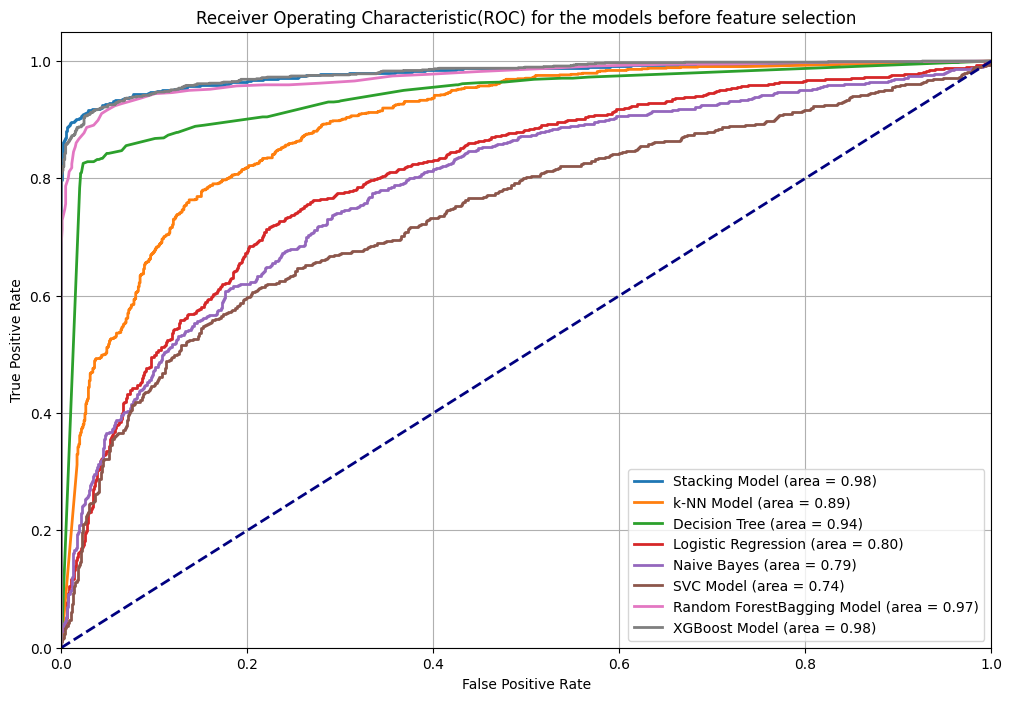

In [180]:


# List of models and their names
models = [
    final_stacking_model,
    final_knn_model,
    final_dt_model,   # Decision Tree Classifier
    final_lr_model,   # Logistic Regression
    final_nb_model,   # Gaussian Naive Bayes
    final_svc_model,
    final_rf_model,
    final_bagging_model,
    final_xgb_model
]

model_names = [
    'Stacking Model',
    'k-NN Model',
    'Decision Tree',
    'Logistic Regression',
    'Naive Bayes',
    'SVC Model',
    'Random Forest'
    'Bagging Model',
    'XGBoost Model'
]

plt.figure(figsize=(12,8))

for model, name in zip(models, model_names):
    try:
        # Check if model has predict_proba method
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(x_test)[:, 1]  # Get probabilities for the positive class
        else:
            # Use decision_function if predict_proba is not available
            y_score = model.decision_function(x_test)  # Get decision scores
    except NotFittedError:
        print(f"Model {name} is not fitted yet.")
        continue

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score)

    # Compute AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')


# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic(ROC) for the models before feature selection')
plt.legend(loc='lower right')
plt.grid(True)  # Optional: adds a grid for better readability

plt.show()



In [181]:
import plotly.graph_objects as go
model_names = ['KNN', 'DTC', 'Logistic R', 'Naive B', 'SVC', 'Random F', 'Bagging', 'XGB', 'Stacking']
precision_values = [knn_test_precision, dt_test_precision, lr_test_precision, nb_test_precision, svc_test_precision,rf_test_precision, bagging_test_precision , xgb_test_precision, stacking_test_precision]
recall_values = [knn_test_recall, dt_test_recall, lr_test_recall, nb_test_recall, svc_test_recall, rf_test_recall, bagging_test_recall, xgb_test_recall, stacking_test_recall]
f1_score_values = [knn_test_f1_score, dt_test_f1_score, lr_test_f1_score, nb_test_f1_score, svc_test_f1_score, rf_test_f1_score, bagging_test_f1_score, xgb_test_f1_score, stacking_test_f1_score]
kf_cv_avg_score = [knn_model_kf_avg_score, dt_model_kf_avg_score, lr_model_kf_avg_score, nb_model_kf_avg_score, svc_model_kf_avg_score, rf_model_kf_avg_score, bagging_kf_avg_score, xgb_kf_avg_score, stacking_kf_avg_score ]
skf_cv_avg_score = [knn_model_skf_avg_score, dt_model_skf_avg_score, lr_model_kf_avg_score, nb_model_skf_avg_score, svc_model_skf_avg_score, rf_model_skf_avg_score, bagging_skf_avg_score, xgb_skf_avg_score, stacking_skf_avg_score ]

max_precision_value = max(precision_values)
max_recall_value = max(recall_values)
max_f1_score_value = max(f1_score_values)
max_kf_avg_score = max(kf_cv_avg_score)
max_skf_avg_score = max(skf_cv_avg_score)
# Create table
fig = go.Figure(data=[go.Table(
    header=dict(values=["Model", "precision", "recall", "f1-score", "k-Fold_CV", "SK-Fold_CV"]),
    cells=dict(
        values=[
          model_names,
          precision_values,
          recall_values,
          f1_score_values,
          kf_cv_avg_score,
          skf_cv_avg_score

        ],
        fill=dict(
             color=[
                 ['#FFF'] * len(model_names),
                 ['#90EE90' if precision == max_precision_value else '#FFF' for precision in precision_values],
                 ['#90EE90' if recall == max_recall_value else '#FFF' for recall in recall_values],
                 ['#90EE90' if f1_score == max_f1_score_value else '#FFF' for f1_score in f1_score_values],
                 ['#90EE90' if kf_avg_score == max_kf_avg_score else '#FFF' for kf_avg_score in kf_cv_avg_score],
                 ['#90EE90' if skf_avg_score == max_skf_avg_score else '#FFF' for skf_avg_score in skf_cv_avg_score]


              ],
        ),
        align="center",

    )

)])

# Update layout to add a title
fig.update_layout(title="Model Performance Metrics before feature selection")

fig.show()


# 8. Feature Selection

In [182]:

categorical_variables = ['Default', 'Intent_DEBTCONSOLIDATION', 'Intent_EDUCATION', 'Intent_HOMEIMPROVEMENT', 'Intent_MEDICAL', 'Intent_PERSONAL', 'Intent_VENTURE', 'Home_MORTGAGE', 'Home_OTHER', 'Home_OWN', 'Home_RENT']


In [183]:
features.head()

,Age,Income,Amount,Percent_income,Default,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Emp_length,Rate
0,23,88000,6625,0.08,1,3,0,0,0,1,0,0,1,0,0,0,2.0,11.22
1,23,30000,1925,0.06,0,2,0,0,0,0,1,0,0,0,0,1,0.0,12.18
2,32,160000,12000,0.07,0,8,1,0,0,0,0,0,1,0,0,0,9.0,7.88
3,29,75000,12000,0.16,0,5,0,0,1,0,0,0,0,0,1,0,3.0,7.51
4,22,28800,14000,0.49,0,2,0,0,0,0,0,1,0,0,0,1,2.0,7.90


In [184]:
categorical_df = x_use[categorical_variables]
categorical_df.head()

,Default,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT
11861,1,0,0,0,0,0,0,0,0,0,0
9691,1,0,0,0,1,0,0,0,0,0,1
9070,0,0,0,0,0,0,0,0,0,0,0
10443,0,0,0,0,0,0,0,0,0,0,0
4118,0,0,0,0,0,0,1,0,0,0,1


# 8.1 Filter method

## chi square test

In [185]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Assuming `categorical_df` and `target` are already defined
x = categorical_df
y = y_use

print(x.shape, y.shape)

# Define and apply the MinMaxScaler to ensure non-negative values
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# Perform the chi-squared test
chi2_values, p_values = chi2(x_scaled, y)

# Create a DataFrame to view the results
chi2_df = pd.DataFrame({
    'Feature': x.columns,
    'Chi2 Value': chi2_values,
    'p-value': p_values
}).sort_values(by='Chi2 Value', ascending=False)

print("Chi-Squared Test Results:")
print(chi2_df)



(9552, 11) (9552,)
Chi-Squared Test Results:
                     Feature  Chi2 Value        p-value
7              Home_MORTGAGE  849.724138  8.347172e-187
6             Intent_VENTURE  390.173451   7.587815e-87
2           Intent_EDUCATION  365.897990   1.463330e-81
9                   Home_OWN  325.468938   9.325651e-73
5            Intent_PERSONAL  252.075421   9.161918e-57
10                 Home_RENT  134.750544   3.743696e-31
1   Intent_DEBTCONSOLIDATION   93.229130   4.657752e-22
4             Intent_MEDICAL   89.213668   3.543919e-21
3     Intent_HOMEIMPROVEMENT   77.132802   1.598404e-18
8                 Home_OTHER    5.555556   1.842213e-02
0                    Default    2.510460   1.130929e-01


In [186]:
selected_names = []
fields = chi2_df[chi2_df['p-value'] <= 0]
fields
for x in fields['Feature']:
    selected_names.append(x)

print(selected_names)


[]


In [187]:
categorical_variables
non_categorical_columns = [col for col in features.columns if col not in categorical_variables]
non_categorical_columns


['Age',
 'Income',
 'Amount',
 'Percent_income',
 'Cred_length',
 'Emp_length',
 'Rate']

In [188]:
non_categorical_columns.extend(selected_names)
df[non_categorical_columns]

,Age,Income,Amount,Percent_income,Cred_length,Emp_length,Rate
0,23,88000,6625,0.08,3,2.0,11.22
1,23,30000,1925,0.06,2,0.0,12.18
2,32,160000,12000,0.07,8,9.0,7.88
3,29,75000,12000,0.16,5,3.0,7.51
4,22,28800,14000,0.49,2,2.0,7.90
...,...,...,...,...,...,...,...
8140,34,98000,16000,0.16,10,19.0,10.99
8141,22,24000,2500,0.10,2,3.0,10.59
8142,22,33000,6500,0.20,4,4.0,6.17
8143,28,18000,3500,0.19,5,12.0,14.22


In [189]:
chi_x_train = x_train[non_categorical_columns]
chi_y_train = y_train

chi_x_val = x_val[non_categorical_columns]
chi_y_val = y_val

In [190]:
chi_x_train.shape

(7164, 7)

In [191]:
model = LogisticRegression(max_iter=5000)
model.fit(chi_x_train, chi_y_train)

LogisticRegression(max_iter=5000)

In [192]:
print(model.score(chi_x_train, chi_y_train))
print(model.score(chi_x_val, chi_y_val))

0.7513958682300391
0.7491624790619765


In [193]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_model_grid_search = GridSearchCV(lr_model, param_grid, cv=5, verbose=3, scoring='accuracy')
lr_model_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.736 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.722 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.731 total time=   0.0s
[CV 4/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.734 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.740 total time=   0.0s
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.755 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.732 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.736 total time=   0.0s
[CV 4/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.743 total time=   0.0s
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.785 total time=   0.1s
[CV 2/5] END C=0

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=6000, solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=3)

## 8.2 feature importance using LASSO

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

<ipython-input-194-b51c9d767a9e>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/s

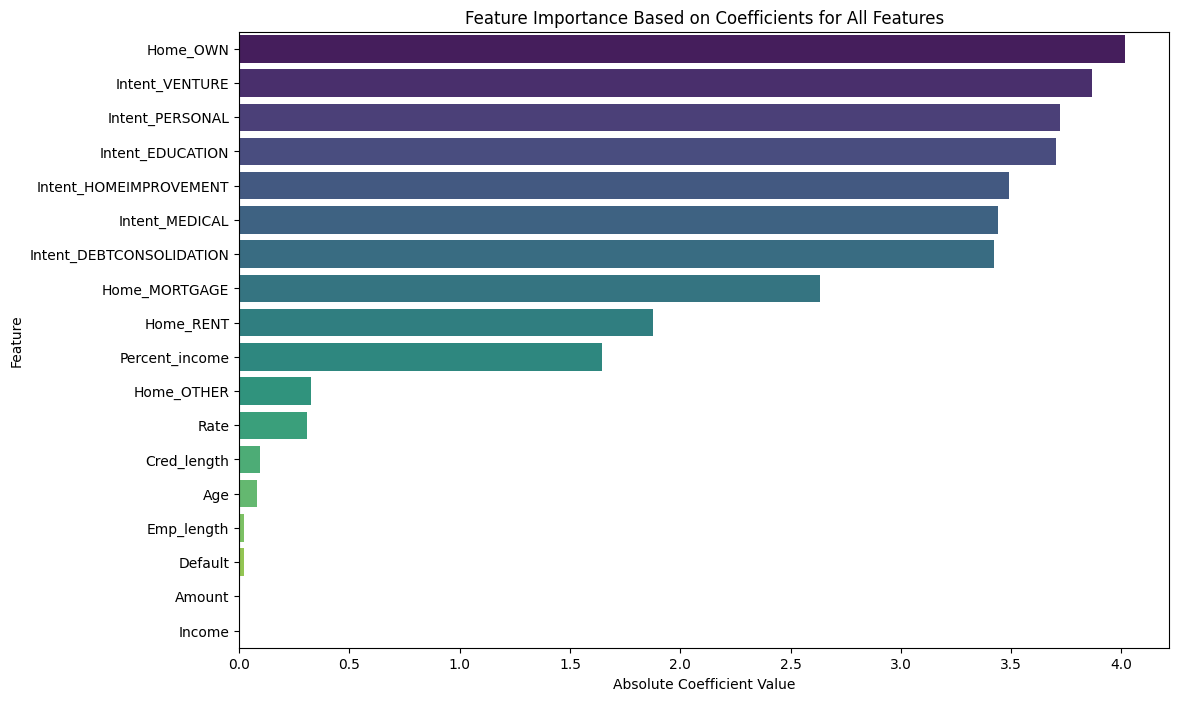

In [194]:



# Assume 'features' is a DataFrame and 'target' is a Series
model = LogisticRegression(max_iter=5000)


# Fit the model on the training dataset
model.fit(x_train, y_train)

# Get the feature names and coefficients
coefficients = model.coef_[0]
feature_names = x_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of coefficients
importance_df['Absolute Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance Based on Coefficients for All Features')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

In [195]:
x_train.shape

(7164, 18)

## 8.3 Wrapper method

## Backward Elimination (wrapper method)

In [196]:
# accuracies = []
# # selecting the best combination of features
# model = LogisticRegression(max_iter=5000)
# for i in range(1, 16):
#   sfs = SequentialFeatureSelector(model, n_features_to_select=i, direction='backward')
#   sfs.fit(x_train, y_train)

#   # Transform the training and test datasets to only include selected features
#   X_train_selected = sfs.transform(x_train)
#   x_val_selected = sfs.transform(x_val)

#   # Fit the model on the selected features
#   model = LogisticRegression(max_iter=5000)
#   model.fit(X_train_selected, y_train)

#   # Predict on the test set
#   y_pred = model.predict(x_val_selected)

#   # Calculate accuracy
#   accuracy = accuracy_score(y_val, y_pred)
#   accuracies.append(accuracy)
#   print(f'Accuracy with the selected top {i} features: {accuracy:.4f}')


## Farward selection (wrapper method)

In [197]:

accuracies = []
# selecting the best combination of features
for i in range(1, 16):
  sfs = SequentialFeatureSelector(model, n_features_to_select=i)
  sfs.fit(x_train, y_train)

  # Transform the training and test datasets to only include selected features
  X_train_selected = sfs.transform(x_train)
  x_val_selected = sfs.transform(x_val)

  # Fit the model on the selected features
  model = LogisticRegression(max_iter=6000, solver='liblinear' )
  model.fit(X_train_selected, y_train)

  # Predict on the test set
  y_pred = model.predict(x_val_selected)

  # Calculate accuracy
  accuracy = accuracy_score(y_val, y_pred)
  accuracies.append(accuracy)
  print(f'Accuracy with the selected top {i} features: {accuracy:.4f}')


# print(f"the highest accuracy {max(accuracies)} gotten with the combination of {accuracies.index(max(accuracies)) + 1}  features ")

Accuracy with the selected top 1 features: 0.6516
Accuracy with the selected top 2 features: 0.7362
Accuracy with the selected top 3 features: 0.7638
Accuracy with the selected top 4 features: 0.7810
Accuracy with the selected top 5 features: 0.8137
Accuracy with the selected top 6 features: 0.8170
Accuracy with the selected top 7 features: 0.8250
Accuracy with the selected top 8 features: 0.8296
Accuracy with the selected top 9 features: 0.8375
Accuracy with the selected top 10 features: 0.8530
Accuracy with the selected top 11 features: 0.8744
Accuracy with the selected top 12 features: 0.8752
Accuracy with the selected top 13 features: 0.8756
Accuracy with the selected top 14 features: 0.8760
Accuracy with the selected top 15 features: 0.8752


In [198]:
print(f"the highest accuracy {max(accuracies)} gotten with the combination of {accuracies.index(max(accuracies)) + 1}  features ")
no_of_features_selected = accuracies.index(max(accuracies)) + 1

the highest accuracy 0.8760469011725294 gotten with the combination of 14  features 


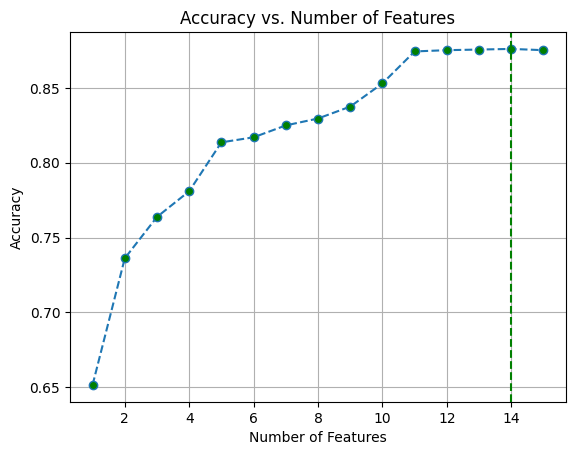

In [199]:
plt.plot(range(1, 16), accuracies, marker='o', linestyle='--', markerfacecolor='green')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Features')
plt.axvline(x=accuracies.index(max(accuracies)) + 1, color='green', linestyle='--')
plt.grid(True)

plt.show()

In [200]:
no_of_features_selected = 14
model = LogisticRegression(max_iter=6000, solver='liblinear' )

sfs = SequentialFeatureSelector(model, n_features_to_select=no_of_features_selected)
sfs.fit(x_train, y_train)
# transform the usable dataset
x_use_selected = sfs.transform(x_use)
# Transform the dataset to only include selected features
x_train_selected = sfs.transform(x_train)
x_val_selected = sfs.transform(x_val)

# Transofrming The test data on only include selected featues too
x_test_selected = sfs.transform(x_test)

# Get the feature names and coefficients for the selected features
selected_feature_names = x_train.columns[sfs.get_support()]

print(selected_feature_names)



Index(['Percent_income', 'Cred_length', 'Intent_DEBTCONSOLIDATION',
       'Intent_EDUCATION', 'Intent_HOMEIMPROVEMENT', 'Intent_MEDICAL',
       'Intent_PERSONAL', 'Intent_VENTURE', 'Home_MORTGAGE', 'Home_OTHER',
       'Home_OWN', 'Home_RENT', 'Emp_length', 'Rate'],
      dtype='object')


In [201]:
# convert x_train_selected and x_val and x_test to a dataframe
x_train_selected = pd.DataFrame(x_train_selected, columns=selected_feature_names)

# Set the correct data types
for column in selected_feature_names:
    if column in ['Percent_income', 'Rate']:
        x_train_selected[column] = x_train_selected[column].astype(float)  # Ensure decimals are floats
        x_train_selected[column] = x_train_selected[column].round(2)
    else:
        x_train_selected[column] = x_train_selected[column].astype(int)  # Other features as integers

x_train_selected.head(2)

,Percent_income,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Emp_length,Rate
0,0.08,7,0,0,0,0,0,0,1,0,0,0,8,10.70
1,0.15,4,0,0,0,0,0,1,0,0,0,1,3,12.76


In [202]:
# converting x_val_selected to dataframe
x_val_selected = pd.DataFrame(x_val_selected, columns=selected_feature_names)

# Set the correct data types
for column in selected_feature_names:
    if column in ['Percent_income', 'Rate']:
        x_val_selected[column] = x_val_selected[column].astype(float)  # Ensure decimals are floats
        x_val_selected[column] = x_val_selected[column].round(2)
    else:
        x_val_selected[column] = x_val_selected[column].astype(int)  # Other features as integers


x_val_selected.head(2)

,Percent_income,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Emp_length,Rate
0,0.05,4,1,0,0,0,0,0,1,0,0,0,5,9.63
1,0.12,10,0,0,0,0,0,1,0,0,0,1,5,6.91


In [203]:
# converting x_test_selected to dataframe
x_test_selected = pd.DataFrame(x_test_selected, columns=selected_feature_names)

# Set the correct data types
for column in selected_feature_names:
    if column in ['Percent_income', 'Rate']:
        x_test_selected[column] = x_test_selected[column].astype(float)  # Ensure decimals are floats
        x_test_selected[column] = x_test_selected[column].round(2)
    else:
        x_test_selected[column] = x_test_selected[column].astype(int)  # Other features as integers


x_test_selected.head(2)

,Percent_income,Cred_length,Intent_DEBTCONSOLIDATION,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Emp_length,Rate
0,0.40,5,0,0,0,0,0,0,0,0,0,0,1,17.64
1,0.15,2,0,0,0,0,0,0,0,0,0,0,0,11.68


# 9 Model Training After feature Selection

# ◉ Logistic Regression (After Feature Selection)

## &rarr; Traing with default parameters

In [204]:
st = time.time()
lr_model_fs=LogisticRegression(max_iter=8000)
et = time.time()
lr_model_fs.fit(x_train_selected, y_train)

LogisticRegression(max_iter=8000)

In [205]:
y_pred = lr_model_fs.predict(x_val_selected)

In [206]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[1085   79]
 [ 215 1009]]

 Classification Report
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1164
           1       0.93      0.82      0.87      1224

    accuracy                           0.88      2388
   macro avg       0.88      0.88      0.88      2388
weighted avg       0.88      0.88      0.88      2388



## &rarr; peforming cross validation

# Stratified K-Fold for Logistic Regression

In [207]:
skf = StratifiedKFold(n_splits=5)
lr_model_fs_skf_score = cross_val_score(lr_model_fs, x_use_selected, y_use, cv=skf)

lr_model_fs_skf_avg_score = round(lr_model_fs_skf_score.mean(),3)

print("the Stratified k-fold sore for logistic regression model is : " , lr_model_fs_skf_score)
print("the Stratified k-fold average sore for logistic regression model is : " , lr_model_fs_skf_avg_score)

the Stratified k-fold sore for logistic regression model is :  [0.88749346 0.86917844 0.87172775 0.88481675 0.87329843]
the Stratified k-fold average sore for logistic regression model is :  0.877


## K-Fold cross validation for Logistic Regression

In [208]:
kf = KFold(n_splits=5)
lr_model_fs_kf_score = cross_val_score(lr_model_fs, x_use_selected, y_use, cv=kf)
lr_model_fs_kf_avg_score = round(lr_model_fs_kf_score.mean(),3)
print("the stratified k-fold score for linear regresion model is :", lr_model_fs_kf_score)
print("the stratified k-fold avg score for linear regresion model is :", lr_model_fs_kf_avg_score)

the stratified k-fold score for linear regresion model is : [0.88644689 0.8707483  0.86963351 0.88848168 0.87225131]
the stratified k-fold avg score for linear regresion model is : 0.878


## &rarr; Hyper parameter tunning

In [209]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_model_fs_grid_search = GridSearchCV(lr_model_fs, param_grid, cv=5, verbose=3, scoring='accuracy')
lr_model_fs_grid_search.fit(x_train_selected, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.629 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.608 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.611 total time=   0.0s
[CV 4/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.604 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.633 total time=   0.0s
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.710 total time=   0.1s
[CV 2/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.686 total time=   0.1s
[CV 3/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.689 total time=   0.1s
[CV 4/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.699 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.691 total time=   0.1s
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.763 total time=   0.0s
[CV 2/5] END C=0

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=8000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=3)

In [210]:
lr_model_fs_best_parameters = lr_model_fs_grid_search.best_params_
print(lr_model_fs_best_parameters)

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


## &rarr; Retrain with best parameters

In [211]:
final_lr_model_fs = LogisticRegression(max_iter=6000, solver='liblinear', C=lr_model_fs_best_parameters['C'], penalty=lr_model_fs_best_parameters['penalty']  )
final_lr_model_fs.fit(x_train_selected, y_train)

LogisticRegression(C=1, max_iter=6000, solver='liblinear')

In [212]:
y_pred = final_lr_model_fs.predict(x_val_selected)

In [213]:
final_lr_model_fs_report = classification_report(y_val, y_pred)
print(final_lr_model_fs_report)

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1164
           1       0.93      0.83      0.87      1224

    accuracy                           0.88      2388
   macro avg       0.88      0.88      0.88      2388
weighted avg       0.88      0.88      0.88      2388



## &rarr; Evaluate on test set (Testing the model )

In [214]:
lr_fs_test_pred = final_lr_model_fs.predict(x_test_selected)

In [215]:
lr_fs_test_report = classification_report(y_test, lr_fs_test_pred)
print(lr_fs_test_report)

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1062
           1       0.94      0.80      0.87      1061

    accuracy                           0.87      2123
   macro avg       0.88      0.87      0.87      2123
weighted avg       0.88      0.87      0.87      2123



In [216]:
lr_fs_test_accuracy = round(accuracy_score(y_test, lr_fs_test_pred),2)
lr_fs_test_recall = round(recall_score(y_test, lr_fs_test_pred),2)
lr_fs_test_precision = round(precision_score(y_test, lr_fs_test_pred),2)
lr_fs_test_f1_score = round(f1_score(y_test, lr_fs_test_pred),2)

print("accuracy : ", lr_fs_test_accuracy)
print("recall : ", lr_fs_test_recall)
print("precision : ", lr_fs_test_precision)
print("f1_score : ", lr_fs_test_f1_score)

accuracy :  0.87
recall :  0.8
precision :  0.94
f1_score :  0.87


## ◉ GaussianNB (Naive Bayes Classifier) After feature selection

In [217]:
nb_model_fs = GaussianNB()
nb_model_fs.fit(x_train_selected, y_train)


GaussianNB()

In [218]:
y_pred = nb_model_fs.predict(x_val_selected)

In [219]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[ 877  287]
 [ 135 1089]]

 Classification Report
              precision    recall  f1-score   support

           0       0.87      0.75      0.81      1164
           1       0.79      0.89      0.84      1224

    accuracy                           0.82      2388
   macro avg       0.83      0.82      0.82      2388
weighted avg       0.83      0.82      0.82      2388



## &rarr; Peforming cross validation

## stratified K-Fold for GaussianNB

In [220]:
skf = StratifiedKFold(n_splits=5)
nb_model_fs_skf_score = cross_val_score(nb_model_fs, x_use_selected, y_use, cv=skf)
print(nb_model_fs_skf_score)
nb_model_fs_skf_avg_score = round(nb_model_fs_skf_score.mean(),3)
print("GaussianNB stratified k-fold score : ", nb_model_fs_skf_avg_score)

[0.80376766 0.7906855  0.80209424 0.81518325 0.80366492]
GaussianNB stratified k-fold score :  0.803


## K-Fold for GaussianNB

In [221]:
kf = KFold(n_splits=5)
nb_model_fs_kf_score = cross_val_score(nb_model_fs, x_use_selected, y_use, cv=kf)
print(nb_model_fs_kf_score)
nb_model_fs_kf_avg_score = round(nb_model_fs_kf_score.mean(),3)

print("the mean avg score for GausianNB kfold cross validatin is :", nb_model_fs_kf_avg_score)

[0.80167452 0.79173208 0.80314136 0.81570681 0.80366492]
the mean avg score for GausianNB kfold cross validatin is : 0.803


## &rarr; Hyper Parameter tunning

In [222]:
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

nb_model_fs_grid_search = GridSearchCV(nb_model_fs, param_grid=param_grid, verbose=3, cv=5)
nb_model_fs_grid_search.fit(x_train_selected, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............var_smoothing=1e-09;, score=0.805 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-09;, score=0.818 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-09;, score=0.784 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-09;, score=0.783 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-09;, score=0.800 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-08;, score=0.805 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-08;, score=0.818 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-08;, score=0.784 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-08;, score=0.783 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-08;, score=0.800 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-07;, score=0.805 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-07;,

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]},
             verbose=3)

In [223]:
nb_model_fs_best_parameters = nb_model_fs_grid_search.best_params_
print(nb_model_fs_best_parameters)

{'var_smoothing': 1e-06}


## &rarr; Retrain the model with best parameters

In [224]:
final_nb_model_fs = GaussianNB(var_smoothing=nb_model_fs_best_parameters['var_smoothing'])
final_nb_model_fs.fit(x_train_selected, y_train)

GaussianNB(var_smoothing=1e-06)

In [225]:
y_pred = final_nb_model_fs.predict(x_val_selected)

In [226]:
final_nb_model_fs_report = classification_report(y_val,y_pred)
print(final_nb_model_fs_report)

              precision    recall  f1-score   support

           0       0.87      0.75      0.81      1164
           1       0.79      0.89      0.84      1224

    accuracy                           0.82      2388
   macro avg       0.83      0.82      0.82      2388
weighted avg       0.83      0.82      0.82      2388



## &rarr; Evaluate GaussianNB model on the test set

In [227]:
nb_fs_test_pred = final_nb_model_fs.predict(x_test_selected)

In [228]:
nb_fs_test_report = classification_report(y_test, nb_fs_test_pred)
print(nb_fs_test_report)

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1062
           1       0.78      0.87      0.83      1061

    accuracy                           0.82      2123
   macro avg       0.82      0.82      0.82      2123
weighted avg       0.82      0.82      0.82      2123



In [229]:
nb_fs_test_accuracy = round(accuracy_score(y_test, nb_fs_test_pred),2)
nb_fs_test_recall = round(recall_score(y_test, nb_fs_test_pred),2)
nb_fs_test_precision = round(precision_score(y_test, nb_fs_test_pred),2)
nb_fs_test_f1_score = round(f1_score(y_test, nb_fs_test_pred),2)

print("accuracy : ", nb_fs_test_accuracy)
print("recall : ", nb_fs_test_recall)
print("precision : ", nb_fs_test_precision)
print("f1_score : ", nb_fs_test_f1_score)

accuracy :  0.82
recall :  0.87
precision :  0.78
f1_score :  0.83


# ◉ KNeighborClassifier


In [230]:
knn_model_fs = KNeighborsClassifier()
knn_model_fs.fit(x_train_selected, y_train)

KNeighborsClassifier()

In [231]:
y_pred = knn_model_fs.predict(x_val_selected)

In [232]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[ 816  348]
 [ 201 1023]]

 Classification Report
              precision    recall  f1-score   support

           0       0.80      0.70      0.75      1164
           1       0.75      0.84      0.79      1224

    accuracy                           0.77      2388
   macro avg       0.77      0.77      0.77      2388
weighted avg       0.77      0.77      0.77      2388



## &rarr; peforming cross-validation

## stratified K-Fold for KNN

In [233]:

skf = StratifiedKFold(n_splits=5)
st = time.time()
knn_model_fs_skf_score = cross_val_score(knn_model_fs, x_use_selected, y_use, cv=skf)
et = time.time()
knn_model_fs_skf_avg_score = knn_model_fs_skf_score.mean()

print("time taken for stratified kfold cross validation on KNN is: ", et-st)
print("the stratified  k-fold score for knn model is :", knn_model_fs_skf_score)
print("the stratified k-fold avg score for knn model is :", knn_model_fs_skf_avg_score)

time taken for stratified kfold cross validation on KNN is:  0.7691929340362549
the stratified  k-fold score for knn model is : [0.77760335 0.76556777 0.76492147 0.77015707 0.78586387]
the stratified k-fold avg score for knn model is : 0.7728227045953298


## K-Fold cross validation for KNN

In [234]:

kfold = KFold(n_splits=5)
st = time.time()
knn_model_kf_score = cross_val_score(knn_model_fs, x_use, y_use, cv=kfold)
et = time.time()
knn_model_fs_kf_avg_score = knn_model_kf_score.mean()

print("time taken for kfold crossvalidaton: ", et-st)
print("the k-fold score for knn model is :", knn_model_kf_score)
print("the k-fold avg score for knn model is :", knn_model_fs_kf_avg_score)

time taken for kfold crossvalidaton:  0.9398303031921387
the k-fold score for knn model is : [0.78021978 0.79434851 0.77382199 0.8        0.79162304]
the k-fold avg score for knn model is : 0.7880026630064026


## &rarr; Hyper parameter tunning (KNeighborClassifier)

In [235]:
param_grid={
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_model_fs_grid_search = GridSearchCV(knn_model_fs, param_grid=param_grid, verbose=3, cv=5)
knn_model_fs_grid_search.fit(x_train_selected, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END n_neighbors=3, p=1, weights=uniform;, score=0.787 total time=   0.1s
[CV 2/5] END n_neighbors=3, p=1, weights=uniform;, score=0.787 total time=   0.1s
[CV 3/5] END n_neighbors=3, p=1, weights=uniform;, score=0.797 total time=   0.1s
[CV 4/5] END n_neighbors=3, p=1, weights=uniform;, score=0.781 total time=   0.1s
[CV 5/5] END n_neighbors=3, p=1, weights=uniform;, score=0.784 total time=   0.1s
[CV 1/5] END n_neighbors=3, p=1, weights=distance;, score=0.785 total time=   0.0s
[CV 2/5] END n_neighbors=3, p=1, weights=distance;, score=0.789 total time=   0.0s
[CV 3/5] END n_neighbors=3, p=1, weights=distance;, score=0.796 total time=   0.0s
[CV 4/5] END n_neighbors=3, p=1, weights=distance;, score=0.780 total time=   0.0s
[CV 5/5] END n_neighbors=3, p=1, weights=distance;, score=0.786 total time=   0.0s
[CV 1/5] END n_neighbors=3, p=2, weights=uniform;, score=0.768 total time=   0.1s
[CV 2/5] END n_neighbors=3, p=2

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [236]:
knn_fs_best_parameters = knn_model_fs_grid_search.best_params_
print(f"the best parameters for the knn model are : {knn_fs_best_parameters}")

the best parameters for the knn model are : {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


## &rarr; Retrain with best parameters

In [237]:
final_knn_model_fs = KNeighborsClassifier(n_neighbors=knn_fs_best_parameters['n_neighbors'], p=knn_fs_best_parameters['p'], weights=knn_fs_best_parameters['weights'])
final_knn_model_fs.fit(x_train_selected, y_train)

KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')

In [238]:
y_pred = final_knn_model_fs.predict(x_val_selected)

In [239]:
final_knn_model_fs_report = classification_report(y_val, y_pred)
print(final_knn_model_fs_report)

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1164
           1       0.78      0.85      0.82      1224

    accuracy                           0.80      2388
   macro avg       0.80      0.80      0.80      2388
weighted avg       0.80      0.80      0.80      2388



## &rarr; evaluate on test set (Testing the model)

In [240]:
knn_fs_test_pred = final_knn_model_fs.predict(x_test_selected)

In [241]:
knn_fs_test_report = classification_report(y_test, knn_fs_test_pred)
accuracy = accuracy_score(y_test, knn_fs_test_pred)
print("accuracy : ", accuracy)
print(knn_fs_test_report)

accuracy :  0.7993405558172397
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1062
           1       0.78      0.84      0.81      1061

    accuracy                           0.80      2123
   macro avg       0.80      0.80      0.80      2123
weighted avg       0.80      0.80      0.80      2123



In [242]:
knn_fs_test_accuracy = round(accuracy_score(y_test, knn_fs_test_pred),2)
knn_fs_test_recall = round(recall_score(y_test, knn_fs_test_pred),2)
knn_fs_test_precision = round(precision_score(y_test, knn_fs_test_pred),2)
knn_fs_test_f1_score = round(f1_score(y_test, knn_fs_test_pred),2)

print("accuracy : ", knn_fs_test_accuracy)
print("recall : ", knn_fs_test_recall)
print("precision : ", knn_fs_test_precision)
print("f1_score : ", knn_fs_test_f1_score)

accuracy :  0.8
recall :  0.84
precision :  0.78
f1_score :  0.81


# ◉ DecissionTreeClassifier (After Feature selection)

In [243]:
dt_model_fs = DecisionTreeClassifier()
dt_model_fs.fit(x_train_selected, y_train)

DecisionTreeClassifier()

In [244]:
y_pred = dt_model_fs.predict(x_val_selected)

In [245]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[ 999  165]
 [ 165 1059]]

 Classification Report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1164
           1       0.87      0.87      0.87      1224

    accuracy                           0.86      2388
   macro avg       0.86      0.86      0.86      2388
weighted avg       0.86      0.86      0.86      2388



## &rarr; peforming cross-validation

## stratified k-Fold for Decision Tree Classifier

In [246]:
# skf stands for Stratified K-Fold

skf = StratifiedKFold(n_splits=5)
st = time.time()
dt_model_fs_skf_score = cross_val_score(dt_model_fs, x_use_selected, y_use, cv=skf)
et = time.time()
dt_model_fs_skf_avg_score = round(dt_model_fs_skf_score.mean(),3)
print("Decision tree skf  average score : ", dt_model_fs_skf_avg_score)
print(dt_model_fs_skf_score)
print("time taken to do k-fold cross validation for decisionTree : ", et-st)

Decision tree skf  average score :  0.866
[0.85609628 0.859236   0.86492147 0.87748691 0.87172775]
time taken to do k-fold cross validation for decisionTree :  0.2603006362915039


## K-Fold cross validation for Desision Tree Classifier

In [247]:
# kf stands for K-Fold

kf = KFold(n_splits=5)
st = time.time()
dt_model_fs_kf_score = cross_val_score(dt_model_fs, x_use_selected, y_use, cv=kf)
et = time.time()
print(dt_model_fs_kf_score)
dt_model_fs_kf_avg_score = round(dt_model_fs_kf_score.mean(),3)
print("Decision tree kf average score : ", dt_model_fs_kf_avg_score)
print("time taken to do  cross validation for decisionTree : ", et-st)

[0.85714286 0.86656201 0.86858639 0.87120419 0.87382199]
Decision tree kf average score :  0.867
time taken to do  cross validation for decisionTree :  0.21621370315551758


## &rarr; Hyper parameter tunning

In [248]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

dt_model_fs_grid_search = GridSearchCV(dt_model_fs, param_grid=param_grid, verbose=3, cv=5)
dt_model_fs_grid_search.fit(x_train_selected, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.854 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.860 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.861 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.847 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.865 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.867 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.880 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.871 total time=  

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=3)

In [249]:
dt_model_fs_best_parameters = dt_model_fs_grid_search.best_params_
print(f"the best parameters for the decision tree model are : {dt_model_fs_best_parameters}")

the best parameters for the decision tree model are : {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}


## &rarr; Retrain the model with best parameters

In [250]:
final_dt_model_fs = DecisionTreeClassifier(criterion=dt_model_fs_best_parameters['criterion'], max_depth= dt_model_fs_best_parameters['max_depth'], min_samples_leaf=dt_model_fs_best_parameters['min_samples_leaf'], min_samples_split=dt_model_fs_best_parameters['min_samples_split'])
final_dt_model_fs.fit(x_train_selected, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=10)

In [251]:
y_pred = final_dt_model_fs.predict(x_val_selected)

In [252]:
final_dt_report = classification_report(y_val, y_pred)
print(final_dt_report)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1164
           1       0.95      0.83      0.89      1224

    accuracy                           0.89      2388
   macro avg       0.90      0.89      0.89      2388
weighted avg       0.90      0.89      0.89      2388



## &rarr; Evaluate on Test set (Testing the Decision tree model)

In [253]:
dt_fs_test_pred = final_dt_model_fs.predict(x_test_selected)

In [254]:
dt_fs_test_report = classification_report(y_test, dt_fs_test_pred)
accuracy = accuracy_score(y_test, dt_fs_test_pred)
print("accuracy : ", accuracy)
print(dt_fs_test_report)

accuracy :  0.8911917098445595
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1062
           1       0.95      0.82      0.88      1061

    accuracy                           0.89      2123
   macro avg       0.90      0.89      0.89      2123
weighted avg       0.90      0.89      0.89      2123



In [255]:
dt_fs_test_accuracy = round(accuracy_score(y_test, dt_fs_test_pred),3)
dt_fs_test_recall = round(recall_score(y_test, dt_fs_test_pred),3)
dt_fs_test_precision = round(precision_score(y_test, dt_fs_test_pred),3)
dt_fs_test_f1_score = round(f1_score(y_test, dt_fs_test_pred),3)

print("accuracy : ", dt_fs_test_accuracy)
print("recall : ", dt_fs_test_recall)
print("precision : ", dt_fs_test_precision)
print("f1_score : ", dt_fs_test_f1_score)

accuracy :  0.891
recall :  0.822
precision :  0.954
f1_score :  0.883


# ◉Support Vector Classifier

## &rarr; Training the model with default parameters

In [256]:
svc_model_fs = SVC()
st = time.time()
svc_model_fs.fit(x_train_selected, y_train)
et = time.time()
svc_model

SVC()

In [257]:
y_pred = svc_model_fs.predict(x_val_selected)

In [258]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[1089   75]
 [ 307  917]]

 Classification Report
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1164
           1       0.92      0.75      0.83      1224

    accuracy                           0.84      2388
   macro avg       0.85      0.84      0.84      2388
weighted avg       0.85      0.84      0.84      2388



## &rarr; Peforming cross-validation

## stratified K-fold for SVC

In [259]:

skf = StratifiedKFold(n_splits=5)
st = time.time()
svc_model_fs_skf_score = cross_val_score(svc_model_fs, x_use_selected, y_use, cv=skf)
et = time.time()
svc_model_fs_skf_avg_score = round(svc_model_fs_skf_score.mean(),3)

print("time taken for stratified kfold cross validation on SVC is: ", et-st)
print(svc_model_fs_skf_score)
print("the mean avg score for SVC kfold cross validatin is :", svc_model_fs_skf_avg_score)


time taken for stratified kfold cross validation on SVC is:  16.26584768295288
[0.84667713 0.84092098 0.8486911  0.83350785 0.84450262]
the mean avg score for SVC kfold cross validatin is : 0.843


## K-Fold cross vallidation for SVC

In [260]:

kf = KFold(n_splits=5)
st = time.time()
svc_model_fs_kf_score = cross_val_score(svc_model_fs, x_use_selected, y_use, cv=kf)
et = time.time()
svc_model_fs_kf_avg_score = round(svc_model_fs_kf_score.mean(),3)
print(svc_model_fs_kf_score)
print("the mean avg score for SVC kfold cross validatin is :", svc_model_fs_kf_avg_score)

print("time taken for kfold crossvalidaton: ", et-st)
# this took 86 sec with the first time check now

[0.84615385 0.84301413 0.84397906 0.83926702 0.84188482]
the mean avg score for SVC kfold cross validatin is : 0.843
time taken for kfold crossvalidaton:  15.621420621871948


## &rarr; Hyper parameter tunning

In [261]:
# commented it out because is taking too long to execute
param_grid = {
    'C': [0.1, 1, 5, 10, 15, 20],
}

svc_model_fs_grid_search = GridSearchCV(svc_model_fs, param_grid=param_grid, verbose=3, cv=5)
svc_model_fs_grid_search.fit(x_train_selected, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .............................C=0.1;, score=0.717 total time=   3.1s
[CV 2/5] END .............................C=0.1;, score=0.709 total time=   2.1s
[CV 3/5] END .............................C=0.1;, score=0.699 total time=   2.1s
[CV 4/5] END .............................C=0.1;, score=0.711 total time=   2.1s
[CV 5/5] END .............................C=0.1;, score=0.698 total time=   1.9s
[CV 1/5] END ...............................C=1;, score=0.839 total time=   1.7s
[CV 2/5] END ...............................C=1;, score=0.844 total time=   2.6s
[CV 3/5] END ...............................C=1;, score=0.833 total time=   2.5s
[CV 4/5] END ...............................C=1;, score=0.826 total time=   1.6s
[CV 5/5] END ...............................C=1;, score=0.845 total time=   1.5s
[CV 1/5] END ...............................C=5;, score=0.858 total time=   1.1s
[CV 2/5] END ...............................C=5;,

GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.1, 1, 5, 10, 15, 20]},
             verbose=3)

In [262]:
svc_model_fs_best_parameters = svc_model_fs_grid_search.best_params_
print(svc_model_fs_best_parameters)

{'C': 20}


In [263]:
final_svc_model_fs = SVC(C=svc_model_fs_best_parameters['C'])
final_svc_model_fs.fit(x_train_selected, y_train)

SVC(C=20)

In [264]:
y_pred = final_svc_model_fs.predict(x_val_selected)

In [265]:
final_svc_model_fs_report = classification_report(y_val, y_pred)
print(final_svc_model_fs_report)

              precision    recall  f1-score   support

           0       0.82      0.96      0.89      1164
           1       0.96      0.80      0.87      1224

    accuracy                           0.88      2388
   macro avg       0.89      0.88      0.88      2388
weighted avg       0.89      0.88      0.88      2388



## &rarr; Evaluate on test set (Testing the SVC model)

In [266]:
svc_fs_test_pred = final_svc_model_fs.predict(x_test_selected)

In [267]:
svc_fs_test_report = classification_report(y_test, svc_fs_test_pred)
print(svc_fs_test_report)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1062
           1       0.96      0.79      0.86      1061

    accuracy                           0.88      2123
   macro avg       0.89      0.88      0.88      2123
weighted avg       0.89      0.88      0.88      2123



In [268]:
svc_fs_test_accracy = round(accuracy_score(y_test, svc_fs_test_pred),2)
svc_fs_test_recall = round(recall_score(y_test, svc_fs_test_pred),2)
svc_fs_test_precision = round(precision_score(y_test, svc_fs_test_pred),2)
svc_fs_test_f1_score = round(f1_score(y_test, svc_fs_test_pred),2)

print("accuracy : ", svc_fs_test_accracy)
print("recall : ", svc_fs_test_recall)
print("precision : ", svc_fs_test_precision)
print("f1_score : ", svc_fs_test_f1_score)

accuracy :  0.88
recall :  0.79
precision :  0.96
f1_score :  0.86


# ● Ensemble Models

## ◉ Bagging Classifier

In [269]:
bagging_fs = BaggingClassifier()
st = time.time()
bagging_fs.fit(x_train_selected, y_train)
et = time.time()
print("time taken for bagging classifier is: ", et-st)
bagging_fs

time taken for bagging classifier is:  0.16749048233032227


BaggingClassifier()

In [270]:
y_pred = bagging_fs.predict(x_val_selected)

In [271]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[1099   65]
 [ 178 1046]]

 Classification Report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1164
           1       0.94      0.85      0.90      1224

    accuracy                           0.90      2388
   macro avg       0.90      0.90      0.90      2388
weighted avg       0.90      0.90      0.90      2388



## &rarr; Peforming Cross-Validation

## KFold cross validation for BaggingClassifier

In [272]:
st = time.time()
kf = KFold(n_splits=5)
bagging_fs_kf_score = cross_val_score(bagging_fs, x_use_selected, y_use, cv=kf)
bagging_fs_kf_avg_score = round(bagging_fs_kf_score.mean(),3)
et = time.time()
print("time taken for kfold cross validation on Bagging Classifier after feature selection is: ", et-st)
print(bagging_fs_kf_score)
print("the mean avg score for Bagging Classifier kfold cross validatin after feature selection is :", bagging_fs_kf_avg_score)

time taken for kfold cross validation on Bagging Classifier after feature selection is:  1.0700409412384033
[0.90737834 0.90005233 0.90628272 0.91465969 0.90366492]
the mean avg score for Bagging Classifier kfold cross validatin after feature selection is : 0.906


## Stratified K-Fold for BaggingClassifier

In [273]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
bagging_fs_skf_score = cross_val_score(bagging_fs, x_use_selected, y_use, cv=skf)
bagging_fs_skf_avg_score = round(bagging_fs_skf_score.mean(),3)
et = time.time()
print("time taken for stratified kfold cross validation on Bagging Classifier after feature selection is: ", et-st)
print(bagging_fs_skf_score)
print("the mean avg score for Bagging Classifier kfold cross validatin after feature selection is :", bagging_fs_skf_avg_score)

time taken for stratified kfold cross validation on Bagging Classifier after feature selection is:  1.043609380722046
[0.90947148 0.89586604 0.90680628 0.90628272 0.90418848]
the mean avg score for Bagging Classifier kfold cross validatin after feature selection is : 0.905


## &rarr; Hyper Parameter tunning for BaggingClassifier

In [274]:
param_grid = {
    'n_estimators': [50, 100, 150, 200]
}

bagging_fs_grid_search = GridSearchCV(bagging_fs, param_grid=param_grid, cv=5)
bagging_fs_grid_search.fit(x_train_selected, y_train)

GridSearchCV(cv=5, estimator=BaggingClassifier(),
             param_grid={'n_estimators': [50, 100, 150, 200]})

In [275]:
bagging_fs_best_parameters = bagging_fs_grid_search.best_params_
print(bagging_fs_best_parameters)

{'n_estimators': 150}


In [276]:
# i will retain the best params from the Bagging classifier below since it takes time to run
# bagging_fs_best_parameters = {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 200}
# print(bagging_fs_best_parameters)

## &rarr; Retrain the Bagging Classifier with best parameters

In [277]:
final_bagging_model_fs = BaggingClassifier(n_estimators=bagging_fs_best_parameters['n_estimators'])
final_bagging_model_fs.fit(x_train_selected, y_train)

BaggingClassifier(n_estimators=150)

In [278]:
y_pred = final_bagging_model_fs.predict(x_val_selected)

In [279]:
final_bagging_model_fs_report = classification_report(y_val, y_pred)
print(final_bagging_model_fs_report)

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1164
           1       0.94      0.87      0.90      1224

    accuracy                           0.90      2388
   macro avg       0.91      0.91      0.90      2388
weighted avg       0.91      0.90      0.90      2388



## &rarr; Evaluate on test set (Testing the model )

In [280]:
bagging_fs_test_pred = final_bagging_model_fs.predict(x_test_selected)

In [281]:
bagging_fs_test_report = classification_report(y_test, bagging_fs_test_pred)
print(bagging_fs_test_report)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1062
           1       0.94      0.86      0.90      1061

    accuracy                           0.90      2123
   macro avg       0.91      0.90      0.90      2123
weighted avg       0.91      0.90      0.90      2123



In [282]:
bagging_fs_test_accuracy = round(accuracy_score(y_test, bagging_fs_test_pred),2)
bagging_fs_test_recall = round(recall_score(y_test, bagging_fs_test_pred),2)
bagging_fs_test_precision = round(precision_score(y_test, bagging_fs_test_pred),2)
bagging_fs_test_f1_score = round(f1_score(y_test, bagging_fs_test_pred),2)

print("accuracy : ", bagging_fs_test_accuracy)
print("recall : ", bagging_fs_test_recall)
print("precision : ", bagging_fs_test_precision)
print("f1_score : ", bagging_fs_test_f1_score)

accuracy :  0.9
recall :  0.86
precision :  0.94
f1_score :  0.9


## ◉ RandomForestClassifier

In [283]:
rf_model_fs = RandomForestClassifier()
st = time.time()
rf_model_fs.fit(x_train_selected, y_train)
et = time.time()
rf_model

RandomForestClassifier()

In [284]:
y_pred = rf_model_fs.predict(x_val_selected)

In [285]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[1118   46]
 [ 157 1067]]

 Classification Report
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1164
           1       0.96      0.87      0.91      1224

    accuracy                           0.91      2388
   macro avg       0.92      0.92      0.91      2388
weighted avg       0.92      0.91      0.91      2388



## &rarr; Peforming cross- validation

## Stratified K-Fold for Random Forest Classifier

In [286]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
rf_model_fs_skf_score = cross_val_score(rf_model_fs, x_use, y_use, cv=skf)
rf_model_fs_skf_avg_score = round(rf_model_skf_score.mean(),2)
et = time.time()
print("time taken for stratified kfold cross validation on Random Forest is: ", et-st)
print(rf_model_fs_skf_score)
print("the mean avg score for Random Forest Classifier kfold cross validatin is :", rf_model_fs_skf_avg_score)


time taken for stratified kfold cross validation on Random Forest is:  5.790452003479004
[0.93563579 0.93458922 0.92774869 0.93769634 0.93193717]
the mean avg score for Random Forest Classifier kfold cross validatin is : 0.93


In [287]:
st = time.time()
kf = KFold(n_splits=5)
rf_model_fs_kf_score = cross_val_score(rf_model_fs, x_use, y_use, cv=kf)
rf_model_fs_kf_avg_score = round(rf_model_fs_kf_score.mean(),3)
et = time.time()
print("time taken for kfold cross validation on Random Forest is: ", et-st)
print(rf_model_fs_kf_score)
print("the mean avg score for Random Forest Classifier kfold cross validatin is :", rf_model_fs_kf_avg_score)


time taken for kfold cross validation on Random Forest is:  7.300053596496582
[0.93668237 0.93458922 0.92617801 0.93350785 0.93350785]
the mean avg score for Random Forest Classifier kfold cross validatin is : 0.933


In [288]:
param_grid = {
    'n_estimators': [50, 100,150, 200],
    'max_depth': [None, 5, 10, 15],
}

rf_model_fs_grid_search = GridSearchCV(rf_model_fs, param_grid=param_grid, verbose=3, cv=5)
rf_model_fs_grid_search.fit(x_train_selected, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...max_depth=None, n_estimators=50;, score=0.909 total time=   0.3s
[CV 2/5] END ...max_depth=None, n_estimators=50;, score=0.913 total time=   0.4s
[CV 3/5] END ...max_depth=None, n_estimators=50;, score=0.909 total time=   0.4s
[CV 4/5] END ...max_depth=None, n_estimators=50;, score=0.896 total time=   0.4s
[CV 5/5] END ...max_depth=None, n_estimators=50;, score=0.911 total time=   0.4s
[CV 1/5] END ..max_depth=None, n_estimators=100;, score=0.909 total time=   0.8s
[CV 2/5] END ..max_depth=None, n_estimators=100;, score=0.911 total time=   0.8s
[CV 3/5] END ..max_depth=None, n_estimators=100;, score=0.911 total time=   0.9s
[CV 4/5] END ..max_depth=None, n_estimators=100;, score=0.904 total time=   0.7s
[CV 5/5] END ..max_depth=None, n_estimators=100;, score=0.918 total time=   0.6s
[CV 1/5] END ..max_depth=None, n_estimators=150;, score=0.911 total time=   0.9s
[CV 2/5] END ..max_depth=None, n_estimators=150;

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=3)

In [289]:
rf_model_fs_best_parameters = rf_model_fs_grid_search.best_params_
print(rf_model_fs_best_parameters)

{'max_depth': 15, 'n_estimators': 200}


In [290]:
final_rf_model_fs = RandomForestClassifier(n_estimators=rf_model_fs_best_parameters['n_estimators'], max_depth=rf_model_fs_best_parameters['max_depth'])
final_rf_model_fs.fit(x_train_selected, y_train)

RandomForestClassifier(max_depth=15, n_estimators=200)

In [291]:
y_pred = final_rf_model_fs.predict(x_val_selected)

In [292]:
final_rf_model_fs_report = classification_report(y_val, y_pred)
print(final_rf_model_fs_report)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1164
           1       0.96      0.87      0.91      1224

    accuracy                           0.92      2388
   macro avg       0.92      0.92      0.92      2388
weighted avg       0.92      0.92      0.92      2388



## &rarr; Evaluate on test set (Testing the model )

In [293]:
rf_fs_test_pred = final_rf_model_fs.predict(x_test_selected)

In [294]:
rf_fs_test_report = classification_report(y_test, rf_test_pred)
print(rf_fs_test_report)

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1062
           1       0.96      0.89      0.93      1061

    accuracy                           0.93      2123
   macro avg       0.93      0.93      0.93      2123
weighted avg       0.93      0.93      0.93      2123



In [295]:
rf_fs_test_accuracy = round(accuracy_score(y_test, rf_fs_test_pred),2)
rf_fs_test_recall = round(recall_score(y_test, rf_fs_test_pred),2)
rf_fs_test_precision = round(precision_score(y_test, rf_fs_test_pred),2)
rf_fs_test_f1_score = round(f1_score(y_test, rf_fs_test_pred),2)

print("accuracy : ", rf_fs_test_accuracy)
print("recall : ", rf_fs_test_recall)
print("precision : ", rf_fs_test_precision)
print("f1_score : ", rf_fs_test_f1_score)

accuracy :  0.91
recall :  0.86
precision :  0.96
f1_score :  0.91


## ◉ XGBClassifier

In [296]:
xgb_fs = XGBClassifier()
st = time.time()
xgb_fs.fit(x_train_selected, y_train)
et = time.time()
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [297]:
y_pred = xgb_fs.predict(x_val_selected)

In [298]:
print("Confusion matrix")
print(confusion_matrix(y_val, y_pred))
print("\n Classification Report")
print(classification_report(y_val, y_pred))

Confusion matrix
[[1116   48]
 [ 158 1066]]

 Classification Report
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1164
           1       0.96      0.87      0.91      1224

    accuracy                           0.91      2388
   macro avg       0.92      0.91      0.91      2388
weighted avg       0.92      0.91      0.91      2388



## &rarr; Peforming cross-validation

## Stratified k-Fold for XGBClassifier

In [299]:
st = time.time()
skf = StratifiedKFold(n_splits=5)
xgb_fs_skf_score = cross_val_score(xgb_fs, x_use_selected, y_use, cv=skf)
xgb_fs_skf_avg_score = round(xgb_fs_skf_score.mean(),3)
et = time.time()
print("time taken for stratified kfold cross validation on XGBClassifier after feature selection  is: ", et-st)
print(xgb_fs_skf_score)
print("the mean avg score for XGBClassifier kfold cross validatin after feature selection  is :", xgb_fs_skf_avg_score)

time taken for stratified kfold cross validation on XGBClassifier after feature selection  is:  0.7681369781494141
[0.9314495  0.91889063 0.91570681 0.92460733 0.91727749]
the mean avg score for XGBClassifier kfold cross validatin after feature selection  is : 0.922


## K-Fold Cross validation for XGBClassifier

In [300]:
st = time.time()
kf = KFold(n_splits=5)
xgb_fs_kf_score = cross_val_score(xgb_fs, x_use_selected, y_use, cv=kf)
xgb_fs_kf_avg_score = round(xgb_kf_score.mean(),3)
et = time.time()
print("time taken for kfold cross validation on XGBClassifier is: ", et-st)
print(xgb_fs_kf_score)
print("the mean avg score for XGBClassifier kfold cross validatin is :", xgb_fs_kf_avg_score)

time taken for kfold cross validation on XGBClassifier is:  0.7224035263061523
[0.93301936 0.92046049 0.91675393 0.92827225 0.91465969]
the mean avg score for XGBClassifier kfold cross validatin is : 0.941


## &rarr; Hyper parameter Tunning

In [301]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],

}

xgb_fs_grid_search = GridSearchCV(estimator=xgb_fs, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_fs_grid_search.fit(x_train_selected, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [302]:
xgb_fs_best_parameters = xgb_fs_grid_search.best_params_
print(xgb_fs_best_parameters)

{'learning_rate': 0.2, 'n_estimators': 50}


In [303]:
# xgb_fs_best_parameters = {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
# print(xgb_fs_best_parameters)

## &rarr; Retrain with best parameter

In [304]:
final_xgb_model_fs = XGBClassifier(n_estimators=xgb_fs_best_parameters['n_estimators'], learning_rate=xgb_fs_best_parameters['learning_rate'])
final_xgb_model_fs.fit(x_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [305]:
y_pred = final_xgb_model_fs.predict(x_val_selected)

In [306]:
final_xgb_model_report = classification_report(y_val, y_pred)
print(final_xgb_model_report)

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1164
           1       0.97      0.87      0.91      1224

    accuracy                           0.92      2388
   macro avg       0.92      0.92      0.92      2388
weighted avg       0.92      0.92      0.92      2388



## &rarr; Evaluate on Test set (Testing)

In [307]:
xgb_fs_test_pred = final_xgb_model_fs.predict(x_test_selected)

In [308]:
xgb_fs_test_report = classification_report(y_test, xgb_fs_test_pred)
print(xgb_fs_test_report)

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1062
           1       0.97      0.86      0.91      1061

    accuracy                           0.91      2123
   macro avg       0.92      0.91      0.91      2123
weighted avg       0.92      0.91      0.91      2123



In [309]:
xgb_fs_test_accuracy = round(accuracy_score(y_test, xgb_fs_test_pred),2)
xgb_fs_test_recall = round(recall_score(y_test, xgb_fs_test_pred),2)
xgb_fs_test_precision = round(precision_score(y_test, xgb_fs_test_pred),2)
xgb_fs_test_f1_score = round(f1_score(y_test, xgb_fs_test_pred),2)

print("accuracy : ", xgb_fs_test_accuracy)
print("recall : ", xgb_fs_test_recall)
print("precision : ", xgb_fs_test_precision)
print("f1_score : ", xgb_fs_test_f1_score)

accuracy :  0.91
recall :  0.86
precision :  0.97
f1_score :  0.91


## ◉ Stacking Classifier

## &rarr; Traing with default parameters

In [310]:

level0 = list()
level0.append(('lr', final_lr_model_fs ))
level0.append(('knn', final_knn_model_fs ))
level0.append(('Dtree', final_dt_model_fs ))
level0.append(('svm', final_svc_model_fs ))
level0.append(('rf', final_rf_model_fs ))
level0.append(('bagging', final_bagging_model_fs ))


level1 = XGBClassifier()

stacking_model_fs = StackingClassifier(estimators=level0, final_estimator=level1)
st = time.time()
stacking_model_fs.fit(x_train_selected, y_train)
et = time.time()
print("time taken for stacking classifier is : ", et-st)
stacking_model_fs

time taken for stacking classifier is :  30.83638882637024


StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=1, max_iter=6000,
                                                   solver='liblinear')),
                               ('knn',
                                KNeighborsClassifier(n_neighbors=9, p=1,
                                                     weights='distance')),
                               ('Dtree',
                                DecisionTreeClassifier(max_depth=10,
                                                       min_samples_split=10)),
                               ('svm', SVC(C=20)),
                               ('rf',
                                RandomForestClassifier(max_depth=15,
                                                       n_estimators=200)),
                               ('bagging',
                                BaggingClassifier(n_estimators...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [311]:
y_pred = stacking_model_fs.predict(x_val_selected)

In [312]:
clr = classification_report(y_val, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1164
           1       0.96      0.86      0.91      1224

    accuracy                           0.91      2388
   macro avg       0.92      0.91      0.91      2388
weighted avg       0.92      0.91      0.91      2388



## &rarr; peform Cross validation for the stacking model

## kFold cross validation for Stacking classifier (After feature selection)

In [313]:
kf = KFold(n_splits=5)
stacking_fs_kf_score = cross_val_score(stacking_model_fs, x_use_selected, y_use, cv=kf)
stacking_fs_kf_avg_score = round(stacking_fs_kf_score.mean(),3)
print(stacking_fs_kf_score)
print("the mean avg score for Stacking Classifier kfold cross validatin after feature selection is :", stacking_fs_kf_avg_score)

[0.91313448 0.90214547 0.9078534  0.91937173 0.91727749]
the mean avg score for Stacking Classifier kfold cross validatin after feature selection is : 0.912


In [314]:
# Retaining the information from the execution above
# stacking_fs_kf_score = [0.91187439, 0.91756624, 0.92149166, 0.91774637, 0.92343934]
# stacking_fs_kf_avg_score =0.918
# print(stacking_fs_kf_score)
# print("the mean avg score for Stacking Classifier kfold cross validatin after feature selection is :", stacking_fs_kf_avg_score)

## Stratified KFold cross validation

In [317]:
skf = StratifiedKFold(n_splits=5)
stacking_fs_skf_score = cross_val_score(stacking_model_fs, x_use_selected, y_use, cv=skf)
stacking_fs_skf_avg_score = round(stacking_fs_skf_score.mean(),3)
print(stacking_fs_skf_score)
print("the mean avg score for Stacking Classifier stratified kfold cross validatin after feature selection is :", stacking_fs_skf_avg_score)

[0.90685505 0.90057561 0.90890052 0.91204188 0.91832461]
the mean avg score for Stacking Classifier stratified kfold cross validatin after feature selection is : 0.909


In [ ]:
# Retaining the information from the execution above
# stacking_fs_skf_score = [0.91697743, 0.91776251, 0.91403337, 0.91382018, 0.92422458]
# stacking_fs_skf_avg_score = 0.917
# print(stacking_fs_skf_score)
# print("the mean avg score for Stacking Classifier stratified kfold cross validatin after feature selection is :", stacking_fs_skf_avg_score)

## &rarr; Hyper parameter Tunning

#### for Stacking i used the already hypertuned models above so there is no need tunning the models again

## &rarr; Retrain with best parameter

In [318]:
# In this case the originally trained stacking model above will be used as the final stacking model
final_stacking_model_fs = stacking_model_fs

## &rarr; Evaluate on Test set (Testing)

In [319]:
stacking_fs_test_pred = final_stacking_model_fs.predict(x_test_selected)

In [320]:
stacking_fs_test_report = classification_report(y_test, stacking_fs_test_pred)
print(stacking_fs_test_report)

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1062
           1       0.97      0.85      0.91      1061

    accuracy                           0.91      2123
   macro avg       0.92      0.91      0.91      2123
weighted avg       0.92      0.91      0.91      2123



In [321]:
stacking_fs_test_accuracy = round(accuracy_score(y_test, stacking_fs_test_pred),2)
stacking_fs_test_recall = round(recall_score(y_test, stacking_fs_test_pred),2)
stacking_fs_test_precision = round(precision_score(y_test, stacking_fs_test_pred),2)
stacking_fs_test_f1_score = round(f1_score(y_test,stacking_fs_test_pred),2)

print("accuracy : ", stacking_fs_test_accuracy)
print("recall : ", stacking_fs_test_recall)
print("precision : ", stacking_fs_test_precision)
print("f1_score : ", stacking_fs_test_f1_score)

accuracy :  0.91
recall :  0.85
precision :  0.97
f1_score :  0.91


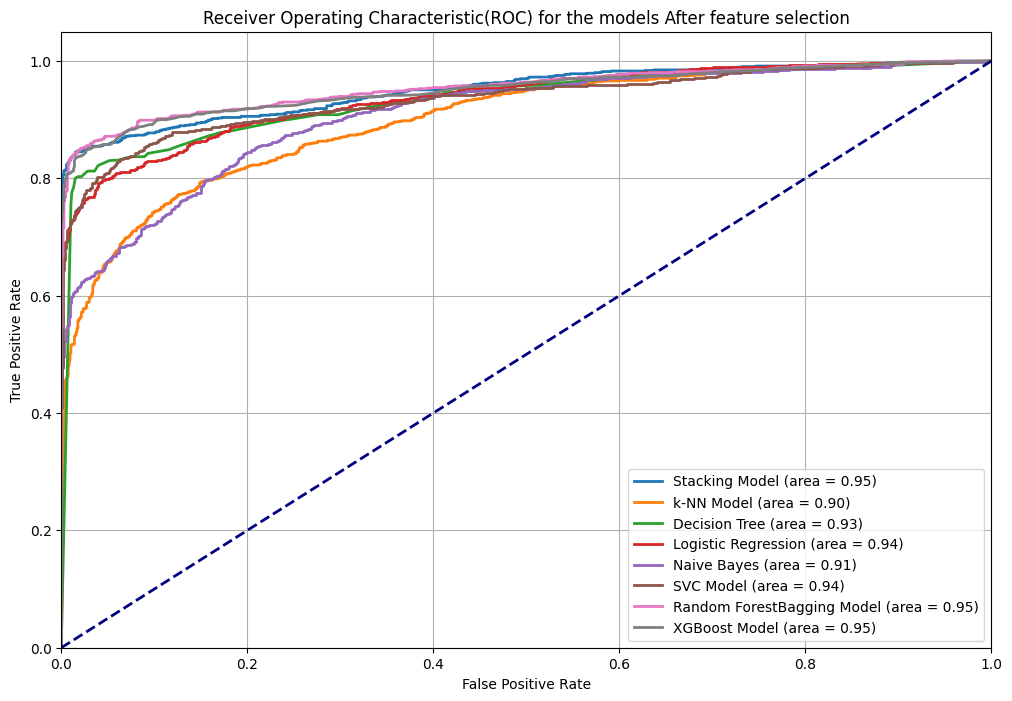

In [322]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.exceptions import NotFittedError

# List of models and their names
models = [
    final_stacking_model_fs,
    final_knn_model_fs,
    final_dt_model_fs,   # Decision Tree Classifier
    final_lr_model_fs,   # Logistic Regression
    final_nb_model_fs,   # Gaussian Naive Bayes
    final_svc_model_fs,
    final_rf_model_fs,
    final_bagging_model_fs,
    final_xgb_model_fs
]

model_names = [
    'Stacking Model',
    'k-NN Model',
    'Decision Tree',
    'Logistic Regression',
    'Naive Bayes',
    'SVC Model',
    'Random Forest'
    'Bagging Model',
    'XGBoost Model'
]

plt.figure(figsize=(12,8))

for model, name in zip(models, model_names):
    try:
        # Check if model has predict_proba method
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(x_test_selected)[:, 1]  # Get probabilities for the positive class
        else:
            # Use decision_function if predict_proba is not available
            y_score = model.decision_function(x_test_selected)  # Get decision scores
    except NotFittedError:
        print(f"Model {name} is not fitted yet.")
        continue

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score)

    # Compute AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')


# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic(ROC) for the models After feature selection')
plt.legend(loc='lower right')
plt.grid(True)  # Optional: adds a grid for better readability

plt.show()



In [323]:
import plotly.graph_objects as go
model_names = ['KNN', 'DTC', 'Logistic R', 'Naive B', 'SVC', 'Random F', 'Bagging', 'XGB', 'Stacking']
precision_values = [knn_fs_test_precision, dt_fs_test_precision, lr_fs_test_precision, nb_fs_test_precision, svc_fs_test_precision,rf_fs_test_precision, bagging_fs_test_precision , xgb_fs_test_precision, stacking_fs_test_precision]
recall_values = [knn_fs_test_recall, dt_fs_test_recall, lr_fs_test_recall, nb_fs_test_recall, svc_fs_test_recall, rf_fs_test_recall, bagging_fs_test_recall, xgb_test_recall, stacking_fs_test_recall]
f1_score_values = [knn_fs_test_f1_score, dt_fs_test_f1_score, lr_fs_test_f1_score, nb_fs_test_f1_score, svc_fs_test_f1_score, rf_fs_test_f1_score, bagging_fs_test_f1_score, xgb_fs_test_f1_score, stacking_fs_test_f1_score]
kf_cv_values = [knn_model_fs_kf_avg_score, dt_model_fs_kf_avg_score, lr_model_fs_kf_avg_score, nb_model_fs_skf_avg_score, svc_model_fs_kf_avg_score, rf_model_fs_kf_avg_score, bagging_fs_kf_avg_score, xgb_fs_kf_avg_score, stacking_fs_kf_avg_score ]
skf_fs_cv_values = [knn_model_fs_skf_avg_score, dt_model_fs_skf_avg_score, lr_model_skf_avg_score, nb_model_skf_avg_score, svc_model_fs_skf_avg_score, rf_model_fs_skf_avg_score, bagging_fs_skf_avg_score, xgb_fs_skf_avg_score, stacking_fs_skf_avg_score ]
max_precision_value = max(precision_values)
max_recall_value = max(recall_values)
max_f1_score_value = max(f1_score_values)
max_kf_cv_value = max(kf_cv_values)
max_skf_fs_cv_value = max(skf_fs_cv_values)

# Create table
fig = go.Figure(data=[go.Table(
    header=dict(values=["Model", "precision", "recall", "f1-score", "kFold-cv", "SKFold-cv"]),
    cells=dict(
        values=[
          model_names,
          precision_values,
          recall_values,
          f1_score_values,
          kf_cv_values,
          skf_fs_cv_values

        ],
        fill=dict(
             color=[
                 ['#FFF'] * len(model_names),
                 ['#90EE90' if precision == max_precision_value else '#FFF' for precision in precision_values],
                 ['#90EE90' if recall == max_recall_value else '#FFF' for recall in recall_values],
                 ['#90EE90' if f1_score == max_f1_score_value else '#FFF' for f1_score in f1_score_values],
                 ['#90EE90' if kf_score == max_kf_cv_value else '#FFF' for kf_score in kf_cv_values],
                 ['#90EE90' if skf_score == max_skf_fs_cv_value else '#FFF' for skf_score in skf_fs_cv_values]


              ],
        ),
        align="center",

    )

)])
# Update layout to add a title
fig.update_layout(title="Model Performance Metrics after feature selection")


fig.show()


# 9. Model Deployment

In [316]:
import pickle
with open('final_random_forest_model.pkl', 'wb') as file:
    pickle.dump(final_rf_model_fs, file)

# 10. Monitoring and Maintinance